In [29]:
import pandas as pd
import numpy as np
from lxml import etree
import xml.etree.ElementTree as ET
import time
import math
import pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns # improves plot aesthetics

# Functions

In [30]:
class DataReader:
  """
  Main class to read in xml files provided by the DFB.

  Returns:
      ElementTree root: The root of the xml document.

  """

  def __init__(self,xml_file):
    self.xml_root = self._load_data(xml_file)


  def _load_data(self,xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    return root

  def create_dataframe(self,df_cols=None,findall_string=".//Object",time_search=None):
    """
    Create a dataframe from the xml inputs

    Args:
        df_cols (list): Optional, the column names. If no names given, columns
          detected automatically
        findall_string (str): The xpath string to iterate trees (https://www.w3schools.com/xml/xml_xpath.asp)
        time_search (float): Will currently look at parent if it's an Event, it
          will compare the time_search to the EventTime. I.e. this is a means of getting
          all passes before the frame time.

    Returns:
        pd.dataframe
    """

    populate_column_names=False
    if df_cols is None:
        df_cols = []
        populate_column_names=True

    out_df = pd.DataFrame(columns = df_cols)

    parent_map = dict((c, p) for p in self.xml_root.getiterator() for c in p)
    for node in self.xml_root.findall(findall_string):
        if time_search is not None:
          if (parent_map[node].tag != "Event"): continue
          event_time = parent_map[node].attrib["EventTime"]
          ts = ciso8601.parse_datetime(event_time)
          # to get time in seconds:
          seconds=time.mktime(ts.timetuple())
          # If timestamp is larger than the search, exit
          if seconds > time_search: continue

        # If column names are not provided, get them
        if populate_column_names==True:
            for key,value in node.attrib.items():
                df_cols.append(key)
                populate_column_names=False

        res = []
        for c in df_cols:
            res.append(node.attrib.get(c))
        out_df = out_df.append(pd.Series(res, index = df_cols), ignore_index=True)
    return out_df


In [31]:
def get_tracking_data(xml_positions, half='firstHalf'):
        """Returns a dataframe with the tracking (position: x, y, z) of all players + the ball
        
        Dropping rows where ball positions is NAN

        +-------+-----------+-----------+
        |       |   BALL    |  TeamId   |
        +       +-----------+-----------+
        |       |  BallId   | PlayerId  |
        + N | T +---+---+---+---+---+---+
        |       | X | Y | Z | X | Y | A |
        +=======+===+===+===+===+===+===+
        | 0 | 0 |123|456|789|012|456|789|
        +-------+-----------+-----------+

        :param xml_positions: the parsed xml tracking data (lxml object)
        :param half: the description of the half: either "firstHalf" or "secondHalf", etc.
        :return: a dataframe containing the tracking data: position of all players and the ball
        """
        def change_type(df, frameset):
            """
            change type of columns
            different columns names and tpyes for the ball and for the rest of the players
            """
            if frameset.attrib.get('TeamId') == 'BALL':
                return df.astype(
                    # change types of columns for the ball
                    dtype={
                        'A':float, 
                        'D':float, 
                        'M':int, 
                        'N':int, 
                        'S':float, 
                        'X':float, 
                        'Y':float,
                        'Z':float,
                        #'T':'datetime64[ns]', # this breaks the timezone
                        'BallPossession':int, 
                        'BallStatus':int,
                    }, 
                    errors='raise'
                )
            else:
                return df.astype(
                    # change types of columns for the players
                    dtype={
                        'A':float, 
                        'D':float, 
                        'M':int, 
                        'N':int, 
                        'S':float, 
                        'X':float, 
                        'Y':float,
                        #'T':'datetime64[ns]', # this breaks the timezone
                    }, 
                    errors='raise'
                )
        

        def create_columns(df, frameset):
            """A utility function to create a multiindex columns"""
            person_id = frameset.attrib.get('PersonId')
            team_id = frameset.attrib.get('TeamId')
            df.columns = pd.MultiIndex.from_product(
                [[team_id], [person_id], df.columns],
                names=['TeamId', 'PersonId', 'Position']
            )
            return df

        tracking_players = pd.concat([
            pd.DataFrame.from_records(
                [dict(frame.attrib) for frame in frameset.getchildren()]
            ).pipe(change_type, frameset=frameset)
             .set_index(['N', 'T'])
             .pipe(create_columns, frameset=frameset)
            for frameset in xml_positions.xpath(F'//Positions/FrameSet[@GameSection = "{half}"]')
        ], axis=1, sort=False)
        
        # this is casting the 'T' values in the index to datetime with the correct time zone
        tracking_players.index.set_levels(pd.to_datetime(tracking_players.index.get_level_values(1)), level=1, inplace = True)

        return tracking_players

In [32]:
def calculateDistance(x1,y1,x2,y2):  
    if np.isnan(x1)==True or np.isnan(y1)==True or np.isnan(x2)==True or np.isnan(y2)==True:
        dist=float('NaN')
    else:
        dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)  
    return dist  

In [33]:
def directionplayframe(frame,teamid):
    ###Check for teamid
    if teamid == CUID1:
        gk_df=cuid1_team_meta_df.loc[cuid1_team_meta_df['PlayingPositionEnglish']=='goalkeeper'] #select goalkeeper information from team with clubid1
        gks=gk_df['ObjectId'] #select only the ids
        frame1=half['1st half'] #define start of first half
        frame2=half['2nd half'] #define start of second half
        if frame<frame2:  #if the selected frame is smaller than frame2 the frame lies within the first half 
            for items in gks.iteritems():  # iterating through the list of goalkeeper
                if (teamid,items[1],'X') in positions.columns:  #if the id is part of the tracking data column names then continue
                    gkpos=positions.loc[(slice(frame1,frame2),),(slice(None),items[1],['X','Y'])] 
                    if gkpos[teamid,items[1],'X'].mean() < 0:
                        dirofplay = 'left to right'
                        return dirofplay
                    else:
                        dirofplay = 'right to left'
                        return dirofplay
        else:
            for items in gks.iteritems():
                if (teamid,items[1],'X') in positions.columns:
                    gkpos=positions.loc[(slice(frame1,frame2),),(slice(None),items[1],['X','Y'])]
                    if gkpos[teamid,items[1],'X'].mean() < 0:
                        dirofplay = 'right to left'
                        return dirofplay
                    else:
                        dirofplay = 'left to right'
                        return dirofplay
    if teamid == CUID2:
        gk_df=cuid2_team_meta_df.loc[cuid2_team_meta_df['PlayingPositionEnglish']=='goalkeeper']
        gks=gk_df['ObjectId']
        frame1=half['1st half']
        frame2=half['2nd half']
        if frame<frame2:
            for items in gks.iteritems():
                if (teamid,items[1],'X') in positions.columns:
                    gkpos=positions.loc[(slice(frame1,frame2),),(slice(None),items[1],['X','Y'])]
                    if gkpos[teamid,items[1],'X'].mean() < 0:
                        dirofplay = 'left to right'
                        return dirofplay
                    else:
                        dirofplay = 'right to left'
                        return dirofplay
        else:
            for items in gks.iteritems():
                if (teamid,items[1],'X') in positions.columns:
                    gkpos=positions.loc[(slice(frame1,frame2),),(slice(None),items[1],['X','Y'])]
                    if gkpos[teamid,items[1],'X'].mean() < 0:
                        dirofplay = 'right to left'
                        return dirofplay
                    else:
                        dirofplay = 'left to right'
                        return dirofplay

In [34]:
##selbe funktion wie createsprintdf mit dem Unterschied, dass auf andere Funktionen zugegriffen wird
def createsprintdf2(half,teamid,playerid,acc,depth,distance):
    dfa=matchinfo.get(half)["Dataframe"][teamid,playerid,'A'][matchinfo.get(half)["Dataframe"][teamid,playerid,'A']>acc]
    startframe=[]
    endframe=[]
    for idx, val in enumerate(dfa):
        if idx==0:
            startframe.append(dfa.index.get_level_values('N')[idx])
        if 0<idx and idx<dfa.count()-1:
            if float(dfa.index.get_level_values('N')[idx])-float(dfa.index.get_level_values('N')[idx-1]) > 50:
                endframe.append(dfa.index.get_level_values('N')[idx-1])
                startframe.append(dfa.index.get_level_values('N')[idx])
        if idx==dfa.count()-1:
            endframe.append(dfa.index.get_level_values('N')[idx])
    sprintframes = {'Startframe': startframe,
                     'Endframe': endframe}
    sprintframesdf = pd.DataFrame(sprintframes,columns= ['Startframe', 'Endframe'])
    sprintframesdf["Adj Endframe"]=0
    sprintframesdf["BP"]=0
    sprintframesdf["FinalThird"]=0
    sprintframesdf["Poss"]=0
    sprintframesdf["Forward"]=0
    sprintframesdf=adjframe2(half,sprintframesdf,matchinfo.get(teamid)["TeamID"],playerid)
    sprintframesdf=calcBP2(half,sprintframesdf,matchinfo.get(teamid)["TeamID"],playerid)
    sprintframesdf=calcfinalthird2(half,sprintframesdf,matchinfo.get(teamid)["TeamID"],playerid,depth)
    sprintframesdf=checkposs2(half,sprintframesdf,matchinfo.get(teamid)["TeamID"],playerid,distance)
    sprintframesdf=forward2(half,sprintframesdf,matchinfo.get(teamid)["TeamID"],playerid)
    return sprintframesdf

In [35]:
def adjframe2 (half,df,teamid, playerid):
    if half==1:
        for i in range(len(df.index)):
            for j in range(1000):
                difspeed=matchinfo.get(teamid)["TeamBallDf1"].loc[df.iloc[i,0]+j+1,(teamid,playerid,("S"))].iat[0]-matchinfo.get(teamid)["TeamBallDf1"].loc[df.iloc[i,0]+j,(teamid,playerid,("S"))].iat[0]
                difspeed2=matchinfo.get(teamid)["TeamBallDf1"].loc[df.iloc[i,0]+j+2,(teamid,playerid,("S"))].iat[0]-matchinfo.get(teamid)["TeamBallDf1"].loc[df.iloc[i,0]+j+1,(teamid,playerid,("S"))].iat[0]
                if difspeed<0 or difspeed2<0:
                    adjend=df.iloc[i,0]+j+1
                    df.iloc[i,2]=adjend
                    break
    if half==2:
        for i in range(len(df.index)):
            for j in range(1000):
                difspeed=matchinfo.get(teamid)["TeamBallDf2"].loc[df.iloc[i,0]+j+1,(teamid,playerid,("S"))].iat[0]-matchinfo.get(teamid)["TeamBallDf2"].loc[df.iloc[i,0]+j,(teamid,playerid,("S"))].iat[0]
                difspeed2=matchinfo.get(teamid)["TeamBallDf2"].loc[df.iloc[i,0]+j+2,(teamid,playerid,("S"))].iat[0]-matchinfo.get(teamid)["TeamBallDf2"].loc[df.iloc[i,0]+j+1,(teamid,playerid,("S"))].iat[0]
                if difspeed<0 or difspeed2<0:
                    adjend=df.iloc[i,0]+j+1
                    df.iloc[i,2]=adjend
                    break
    return df

In [36]:
def calcBP2(half,df,teamid,playerid):
    for i in range(len(df.index)):
        ballposs=(matchinfo.get(half)["Dataframe"].loc[(slice(df.iloc[i,0],df.iloc[i,2]),),("BALL","DFL-OBJ-0000XT","BallPossession")]==matchinfo.get(teamid)["BallPoss"]).sum()
        if ballposs/len(matchinfo.get(half)["Dataframe"].loc[(slice(df.iloc[i,0],df.iloc[i,2])),("BALL","DFL-OBJ-0000XT","BallPossession")].index)>0.5:
            df.loc[i,"BP"]="Yes"
        else:
            df.loc[i,"BP"]="No"
    return df

In [37]:
def calcfinalthird2(half,df,teamid,playerid,depth):
    for i in range(len(df.index)):
        if matchinfo.get(teamid)[half]=="left to right":
            if (matchinfo.get(half)["Dataframe"].loc[(slice(df.iloc[i,0],df.iloc[i,2]),),(teamid,playerid,"X")]>=depth).sum()/len(matchinfo.get(half)["Dataframe"].loc[(slice(df.iloc[i,0],df.iloc[i,2])),:].index)>0.5:
                df.loc[i,"FinalThird"]="Yes"
            else:
                df.loc[i,"FinalThird"]="No"
        if matchinfo.get(teamid)[half]=="right to left":
            if (matchinfo.get(half)["Dataframe"].loc[(slice(df.iloc[i,0],df.iloc[i,2]),),(teamid,playerid,"X")]<=-depth).sum()/len(matchinfo.get(half)["Dataframe"].loc[(slice(df.iloc[i,0],df.iloc[i,2])),:].index)>0.5:
                df.loc[i,"FinalThird"]="Yes"
            else:
                df.loc[i,"FinalThird"]="No"         
    return df

In [38]:
##Überprüft ob der Spieler im Zeitfenster Ballkontakt hatte oder nicht
##die länge des Zeitfensters wird berechnet, es wird sich die erste hälfte des zeitfenster angeguckt, wenn die distanz zum ball kleiner als 1 meter für die erste hälfte der zeitspanne ist
##wird ein Yes gelabelt und sonst No, wenn mehr als 25% des Zeitfensters der ball näher als 1 meter vom spieler entfernt ist, so wird dem spieler in der phase ballbesitz zugerechnet
def checkposs2(half,df,teamid,playerid,distance):
    for i in range(len(df.index)):
        startphase=math.ceil((df.iloc[i,2]-df.iloc[i,0])/2)
        if (matchinfo.get(half)["Dataframe"].loc[(slice(df.iloc[i,0],df.iloc[i,0]+startphase),),(teamid,playerid,"DtB")]<=distance).sum()>=startphase/2:
            df.loc[i,"Poss"]="Yes"
        else:
            df.loc[i,"Poss"]="No"
    return df

In [39]:
def forward2(half,df,teamid,playerid):
    for i in range(len(df.index)):
        for j in range(df.iloc[i,2]-df.iloc[i,0]):
            if matchinfo.get(teamid)[half]=="left to right":
                if matchinfo.get(half)["Dataframe"].loc[df.iloc[i,0]+j+1,(teamid,playerid,"X")].iat[0]-matchinfo.get(half)["Dataframe"].loc[df.iloc[i,0]+j,(teamid,playerid,"X")].iat[0]<0:
                    df.loc[i,"Forward"]="No"
                    break
                else:
                    df.loc[i,"Forward"]="Yes"
            if matchinfo.get(teamid)[half]=="right to left":
                if matchinfo.get(half)["Dataframe"].loc[df.iloc[i,0]+j+1,(teamid,playerid,"X")].iat[0]-matchinfo.get(half)["Dataframe"].loc[df.iloc[i,0]+j,(teamid,playerid,"X")].iat[0]>0:
                    df.loc[i,"Forward"]="No"
                    break
                else:
                    df.loc[i,"Forward"]="Yes" 
    return df

In [40]:
def getteamsheet(teamid,half):
    teamsheet=matchinfo.get(half)["Dataframe"].loc[matchinfo.get(half)["Dataframe"].index.get_level_values(0)[0],(teamid,slice(None),"X")].columns.get_level_values(level=1).unique()
    return teamsheet

In [57]:
def getdirectionofplay(teamid,half):
    if matchinfo.get(half)["Dataframe"].loc[matchinfo.get(half)["Dataframe"].index.get_level_values(0)[0],(teamid,slice(None),"X")].mean(axis=1).iat[0] < 0:
        dirofplay = 'left to right'
    if matchinfo.get(half)["Dataframe"].loc[matchinfo.get(half)["Dataframe"].index.get_level_values(0)[0],(teamid,slice(None),"X")].mean(axis=1).iat[0] > 0:
        dirofplay = 'right to left'
    return  dirofplay

In [60]:
def possession(teamid,half,style):
    
    if style=="standard":
        #anz=((balldf2.loc[:,("BALL","DFL-OBJ-0000XT","BallStatus")]==1) & (balldf2.loc[:,("BALL","DFL-OBJ-0000XT","BallPossession")]==1) & (balldf2.loc[:,("BALL","DFL-OBJ-0000XT","X")]>=0)).sum()
        anz=((matchinfo.get(half)["BallDf"].loc[:,("BALL","DFL-OBJ-0000XT","BallPossession")]==matchinfo.get(teamid)["BallPoss"])).sum()
        ges=len(matchinfo.get(half)["BallDf"].loc[:,("BALL","DFL-OBJ-0000XT","BallPossession")])
        poss=anz/ges
        minutes= anz/1500
        
    if style=="cleaned standard":
        anz=((matchinfo.get(half)["BallDf"].loc[:,("BALL","DFL-OBJ-0000XT","BallPossession")]==matchinfo.get(teamid)["BallPoss"]) & (matchinfo.get(half)["BallDf"].loc[:,("BALL","DFL-OBJ-0000XT","BallStatus")]==1)).sum()
        ges=((matchinfo.get(half)["BallDf"].loc[:,("BALL","DFL-OBJ-0000XT","BallStatus")]==1)).sum()
        poss=anz/ges
        minutes= anz/1500
        
    if style=="opposing half":
        if matchinfo.get(teamid)[half]=="left to right":
            #anz=((balldf2.loc[:,("BALL","DFL-OBJ-0000XT","BallStatus")]==1) & (balldf2.loc[:,("BALL","DFL-OBJ-0000XT","BallPossession")]==1) & (balldf2.loc[:,("BALL","DFL-OBJ-0000XT","X")]>=0)).sum()
            anz=((matchinfo.get(half)["BallDf"].loc[:,("BALL","DFL-OBJ-0000XT","BallPossession")]==matchinfo.get(teamid)["BallPoss"]) & (matchinfo.get(half)["BallDf"].loc[:,("BALL","DFL-OBJ-0000XT","X")]>=0)).sum()
            ges=((matchinfo.get(half)["BallDf"].loc[:,("BALL","DFL-OBJ-0000XT","BallPossession")]==matchinfo.get(teamid)["BallPoss"])).sum()
            poss=anz/ges
            minutes= anz/1500
        if matchinfo.get(teamid)[half]=="right to left":
            anz=((matchinfo.get(half)["BallDf"].loc[:,("BALL","DFL-OBJ-0000XT","BallPossession")]==matchinfo.get(teamid)["BallPoss"]) & (matchinfo.get(half)["BallDf"].loc[:,("BALL","DFL-OBJ-0000XT","X")]<=0)).sum()
            ges=((matchinfo.get(half)["BallDf"].loc[:,("BALL","DFL-OBJ-0000XT","BallPossession")]==matchinfo.get(teamid)["BallPoss"])).sum()
            poss=anz/ges
            minutes= anz/1500

    return poss,minutes

# Test

In [2]:
xml_positions = etree.parse('C:/Users/Jung/Desktop/Q-Index Master/19-06-12_Mainz_GER_EST Sportec Data/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-003BEU.xml') ##arbeitsplatop

In [5]:
kpimerged = pd.read_excel('C:/Users/Jung/Desktop/Q-Index Master/19-06-12_Mainz_GER_EST Sportec Data/DFB_KPI_Merged.xlsx') #arbeit

In [6]:
path='C:/Users/Jung/Desktop/Q-Index Master/19-06-12_Mainz_GER_EST Sportec Data/'    #arbeit

In [5]:
path='C:/Users/Tim/Desktop/QIndex/data/19-06-12_Mainz_GER_EST Sportec Data/'    #Privat

In [41]:
xml_positions = etree.parse('C:/Users/Tim/Desktop/QIndex/data/19-06-12_Mainz_GER_EST Sportec Data/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-003BEU.xml') ##privat
kpimerged = pd.read_excel('C:/Users/Tim/Desktop/QIndex/data/19-06-12_Mainz_GER_EST Sportec Data/DFB_KPI_Merged.xlsx') ##privat

In [7]:
kpimergednew = kpimerged.rename({'FRAME_NUMBER': 'N'}, axis=1)

In [10]:
positions=get_tracking_data(xml_positions)     
##create dataframe from xml input

In [11]:
CUID1 = 'DFL-CLU-000N8Y'
cuid1_player_info = "DFL_01_05_masterdata_{}_DFL-SEA-0001K3_player (1).xml".format(CUID1)
cuid1_team_data = DataReader(path+cuid1_player_info)
cuid1_team_meta_df = cuid1_team_data.create_dataframe()
cuid1_player_IDs = cuid1_team_meta_df.ObjectId.tolist()

In [12]:
CUID2 = 'DFL-CLU-000N8Z'
cuid2_player_info = "DFL_01_05_masterdata_{}_DFL-SEA-0001K3_player (1).xml".format(CUID2)
cuid2_team_data = DataReader(path+cuid2_player_info)
cuid2_team_meta_df = cuid2_team_data.create_dataframe()
cuid2_player_IDs = cuid2_team_meta_df.ObjectId.tolist()

In [161]:
matchinfo = {
    CUID1: {
        1:"left to right",
        2:"right to left",
        "BallPoss":1,
        "TeamBallDf1":cuid1balldf,
        "TeamBallDf2":cuid1balldf2,
        "TeamID":CUID1,
    },
    CUID2: {
        1:"right to left",
        2:"left to right",
        "BallPoss":2,
        "TeamBallDf1":cuid2balldf,
        "TeamBallDf2":cuid2balldf2,
        "TeamID":CUID2,
    },
    1: {
       "BallDf":balldf, 
       "Positions":positions,
    },
    2: {
       "BallDf":balldf2,
       "Positions":positions2,
    }
}

In [14]:
#calculates distance to ball for every player playing 1.half
players=positions.columns.get_level_values(level=1).unique()
for player in players:
    if player in cuid1_player_IDs:
        positions[CUID1,player,'DtB']=positions.apply(lambda x: calculateDistance(x[CUID1,player,'X'],x[CUID1,player,'Y'],x['BALL','DFL-OBJ-0000XT','X'],x['BALL','DFL-OBJ-0000XT','Y']),axis=1)
    if player in cuid2_player_IDs:
        positions[CUID2,player,'DtB']=positions.apply(lambda x: calculateDistance(x[CUID2,player,'X'],x[CUID2,player,'Y'],x['BALL','DFL-OBJ-0000XT','X'],x['BALL','DFL-OBJ-0000XT','Y']),axis=1)

In [16]:
half={} # frames der kickoff zeiten in frames
kickoffs=kpimergednew[(kpimergednew['SUBTYPE']=='Kickoff')].index.tolist()
for i in kickoffs:
    if i != 0:
        framedif=kpimergednew.iloc[i].N -kpimergednew.iloc[i-2].N
        if framedif > 10000:
            half['2nd half']=kpimergednew.iloc[i].N
    else:
        half['1st half']=kpimergednew.iloc[i].N

In [22]:
balldf=positions.loc[:,("BALL","DFL-OBJ-0000XT",slice(None))]   ##Ballkoordinaten 1. Halbzeit
CUID1df = positions.loc[:,(CUID1,slice(None),slice(None))]     ##Koordinaten von CUID1 1. Halbzeit
cuid1players=CUID1df.columns.get_level_values(level=1).unique()        ##Spieler, die in der 1. Halbzeit auf dem Platz standen
cuid1balldf=pd.merge(CUID1df, balldf, left_index=True, right_index=True)   ##Gemergter Dataframe Ball und CUID1 1. Halbzeit

In [23]:
CUID2df = positions.loc[:,(CUID2,slice(None),slice(None))]     ##Koordinaten von CUID2 1. Halbzeit
cuid2players=CUID2df.columns.get_level_values(level=1).unique()        ##Spieler, die in der 1. Halbzeit auf dem Platz standen
cuid2balldf=pd.merge(CUID2df, balldf, left_index=True, right_index=True)   ##Gemergter Dataframe Ball und CUID1 1. Halbzeit

In [145]:
##selbe funktion wie createsprintdf mit dem Unterschied, dass auf andere Funktionen zugegriffen wird
def createsprintdf(half,teamid,playerid,acc,depth,distance):
    if half==1:
        half=1
        dfa=positions[teamid,playerid,'A'][positions[teamid,playerid,'A']>acc]
        startframe=[]
        endframe=[]
        for idx, val in enumerate(dfa):
            if idx==0:
                 startframe.append(dfa.index.get_level_values('N')[idx])
            if 0<idx and idx<dfa.count()-1:
                if float(dfa.index.get_level_values('N')[idx])-float(dfa.index.get_level_values('N')[idx-1]) > 50:
                    endframe.append(dfa.index.get_level_values('N')[idx-1])
                    startframe.append(dfa.index.get_level_values('N')[idx])
            if idx==dfa.count()-1:
                endframe.append(dfa.index.get_level_values('N')[idx])
        sprintframes = {'Startframe': startframe,
                     'Endframe': endframe}
        sprintframesdf = pd.DataFrame(sprintframes,columns= ['Startframe', 'Endframe'])
        sprintframesdf["Adj Endframe"]=0
        sprintframesdf["BP"]=0
        sprintframesdf["FinalThird"]=0
        sprintframesdf["Poss"]=0
        sprintframesdf=adjframe(half,sprintframesdf,playerid)
        sprintframesdf=calcBP(half,sprintframesdf,playerid)
        sprintframesdf=calcfinalthird(half,sprintframesdf,playerid,depth)
        sprintframesdf=checkposs(half,sprintframesdf,playerid,distance)
    if half==2:
        half=2
        dfa=positions2[teamid,playerid,'A'][positions2[teamid,playerid,'A']>acc]
        startframe=[]
        endframe=[]
        for idx, val in enumerate(dfa):
            if idx==0:
                 startframe.append(dfa.index.get_level_values('N')[idx])
            if 0<idx and idx<dfa.count()-1:
                if float(dfa.index.get_level_values('N')[idx])-float(dfa.index.get_level_values('N')[idx-1]) > 50:
                    endframe.append(dfa.index.get_level_values('N')[idx-1])
                    startframe.append(dfa.index.get_level_values('N')[idx])
            if idx==dfa.count()-1:
                endframe.append(dfa.index.get_level_values('N')[idx])
        sprintframes = {'Startframe': startframe,
                     'Endframe': endframe}
        sprintframesdf = pd.DataFrame(sprintframes,columns= ['Startframe', 'Endframe'])
        sprintframesdf["Adj Endframe"]=0
        sprintframesdf["BP"]=0
        sprintframesdf["FinalThird"]=0
        sprintframesdf["Poss"]=0
        sprintframesdf=adjframe(half,sprintframesdf,playerid)
        sprintframesdf=calcBP(half,sprintframesdf,playerid)
        sprintframesdf=calcfinalthird(half,sprintframesdf,playerid,depth)
        sprintframesdf=checkposs(half,sprintframesdf,playerid,distance)
    return sprintframesdf

In [18]:
def adjframe (half,df, playerid):
    if playerid in cuid1_player_IDs:
        if half==1:
            for i in range(len(df.index)):
                for j in range(1000):
                    difspeed=cuid1balldf.loc[df.iloc[i,0]+j+1,(CUID1,playerid,("S"))].iat[0]-cuid1balldf.loc[df.iloc[i,0]+j,(CUID1,playerid,("S"))].iat[0]
                    difspeed2=cuid1balldf.loc[df.iloc[i,0]+j+2,(CUID1,playerid,("S"))].iat[0]-cuid1balldf.loc[df.iloc[i,0]+j+1,(CUID1,playerid,("S"))].iat[0]
                    if difspeed<0 or difspeed2<0:
                        adjend=df.iloc[i,0]+j+1
                        df.iloc[i,2]=adjend
                        break
        if half==2:
            for i in range(len(df.index)):
                for j in range(1000):
                    difspeed=cuid1balldf2.loc[df.iloc[i,0]+j+1,(CUID1,playerid,("S"))].iat[0]-cuid1balldf2.loc[df.iloc[i,0]+j,(CUID1,playerid,("S"))].iat[0]
                    difspeed2=cuid1balldf2.loc[df.iloc[i,0]+j+2,(CUID1,playerid,("S"))].iat[0]-cuid1balldf2.loc[df.iloc[i,0]+j+1,(CUID1,playerid,("S"))].iat[0]
                    if difspeed<0 or difspeed2<0:
                        adjend=df.iloc[i,0]+j+1
                        df.iloc[i,2]=adjend
                        break
    if playerid in cuid2_player_IDs:
        if half==1:
            for i in range(len(df.index)):
                for j in range(1000):
                    difspeed=cuid2balldf.loc[df.iloc[i,0]+j+1,(CUID2,playerid,("S"))].iat[0]-cuid2balldf.loc[df.iloc[i,0]+j,(CUID2,playerid,("S"))].iat[0]
                    difspeed2=cuid2balldf.loc[df.iloc[i,0]+j+2,(CUID2,playerid,("S"))].iat[0]-cuid2balldf.loc[df.iloc[i,0]+j+1,(CUID2,playerid,("S"))].iat[0]
                    if difspeed<0 or difspeed2<0:
                        adjend=df.iloc[i,0]+j+1
                        df.iloc[i,2]=adjend
                        break
        if half==2:
            for i in range(len(df.index)):
                for j in range(1000):
                    difspeed=cuid2balldf2.loc[df.iloc[i,0]+j+1,(CUID2,playerid,("S"))].iat[0]-cuid2balldf2.loc[df.iloc[i,0]+j,(CUID2,playerid,("S"))].iat[0]
                    difspeed2=cuid2balldf2.loc[df.iloc[i,0]+j+2,(CUID2,playerid,("S"))].iat[0]-cuid2balldf2.loc[df.iloc[i,0]+j+1,(CUID2,playerid,("S"))].iat[0]
                    if difspeed<0 or difspeed2<0:
                        adjend=df.iloc[i,0]+j+1
                        df.iloc[i,2]=adjend
                        break
    return df

In [19]:
def calcBP(half,df,playerid):
    if playerid in cuid1_player_IDs:
        if half==1:
            for i in range(len(df.index)):
                ballposs=(positions.loc[(slice(df.iloc[i,0],df.iloc[i,2]),),("BALL","DFL-OBJ-0000XT","BallPossession")]==1).sum()
                if ballposs/len(positions.loc[(slice(df.iloc[i,0],df.iloc[i,2])),("BALL","DFL-OBJ-0000XT","BallPossession")].index)>0.5:
                    df.loc[i,"BP"]="Yes"
                else:
                    df.loc[i,"BP"]="No"
        if half==2:
            for i in range(len(df.index)):
                ballposs=(positions2.loc[(slice(df.iloc[i,0],df.iloc[i,2]),),("BALL","DFL-OBJ-0000XT","BallPossession")]==1).sum()
                if ballposs/len(positions2.loc[(slice(df.iloc[i,0],df.iloc[i,2])),("BALL","DFL-OBJ-0000XT","BallPossession")].index)>0.5:
                    df.loc[i,"BP"]="Yes"
                else:
                    df.loc[i,"BP"]="No"
    if playerid in cuid2_player_IDs:
        if half==1:
            for i in range(len(df.index)):
                ballposs=(positions.loc[(slice(df.iloc[i,0],df.iloc[i,2]),),("BALL","DFL-OBJ-0000XT","BallPossession")]==2).sum()
                if ballposs/len(positions.loc[(slice(df.iloc[i,0],df.iloc[i,2])),("BALL","DFL-OBJ-0000XT","BallPossession")].index)>0.5:
                    df.loc[i,"BP"]="Yes"
                else:
                    df.loc[i,"BP"]="No"
        if half==2:
            for i in range(len(df.index)):
                ballposs=(positions2.loc[(slice(df.iloc[i,0],df.iloc[i,2]),),("BALL","DFL-OBJ-0000XT","BallPossession")]==2).sum()
                if ballposs/len(positions2.loc[(slice(df.iloc[i,0],df.iloc[i,2])),("BALL","DFL-OBJ-0000XT","BallPossession")].index)>0.5:
                    df.loc[i,"BP"]="Yes"
                else:
                    df.loc[i,"BP"]="No"
    return df

In [20]:
def calcfinalthird(half,df,playerid,depth):
    if playerid in cuid1_player_IDs:
        if half==1:
            for i in range(len(df.index)):
                if directionplayframe(df.iloc[i,0],CUID1)=="left to right":
                    if (positions.loc[(slice(df.iloc[i,0],df.iloc[i,2]),),(CUID1,playerid,"X")]>=depth).sum()/len(positions.loc[(slice(df.iloc[i,0],df.iloc[i,2])),:].index)>0.5:
                        df.loc[i,"FinalThird"]="Yes"
                    else:
                        df.loc[i,"FinalThird"]="No"
                if directionplayframe(df.iloc[i,0],CUID1)=="right to left":
                    if (positions.loc[(slice(df.iloc[i,0],df.iloc[i,2]),),(CUID1,playerid,"X")]<=-depth).sum()/len(positions.loc[(slice(df.iloc[i,0],df.iloc[i,2])),:].index)>0.5:
                        df.loc[i,"FinalThird"]="Yes"
                    else:
                        df.loc[i,"FinalThird"]="No"
        if half==2:
            for i in range(len(df.index)):
                if directionplayframe(df.iloc[i,0],CUID1)=="left to right":
                    if (positions2.loc[(slice(df.iloc[i,0],df.iloc[i,2]),),(CUID1,playerid,"X")]>=depth).sum()/len(positions2.loc[(slice(df.iloc[i,0],df.iloc[i,2])),:].index)>0.5:
                        df.loc[i,"FinalThird"]="Yes"
                    else:
                        df.loc[i,"FinalThird"]="No"
                if directionplayframe(df.iloc[i,0],CUID1)=="right to left":
                    if (positions2.loc[(slice(df.iloc[i,0],df.iloc[i,2]),),(CUID1,playerid,"X")]<=-depth).sum()/len(positions2.loc[(slice(df.iloc[i,0],df.iloc[i,2])),:].index)>0.5:
                        df.loc[i,"FinalThird"]="Yes"
                    else:
                        df.loc[i,"FinalThird"]="No"            
    if playerid in cuid2_player_IDs:
        if half ==1:
            for i in range(len(df.index)):
                if directionplayframe(df.iloc[i,0],CUID2)=="left to right":
                    if (positions.loc[(slice(df.iloc[i,0],df.iloc[i,2]),),(CUID2,playerid,"X")]>=depth).sum()/len(positions.loc[(slice(df.iloc[i,0],df.iloc[i,2])),:].index)>0.5:
                        df.loc[i,"FinalThird"]="Yes"
                    else:
                        df.loc[i,"FinalThird"]="No"
                if directionplayframe(df.iloc[i,0],CUID2)=="right to left":
                    if (positions.loc[(slice(df.iloc[i,0],df.iloc[i,2]),),(CUID2,playerid,"X")]<=-depth).sum()/len(positions.loc[(slice(df.iloc[i,0],df.iloc[i,2])),:].index)>0.5:
                        df.loc[i,"FinalThird"]="Yes"
                    else:
                        df.loc[i,"FinalThird"]="No"
        if half==2:
            for i in range(len(df.index)):
                if directionplayframe(df.iloc[i,0],CUID2)=="left to right":
                    if (positions2.loc[(slice(df.iloc[i,0],df.iloc[i,2]),),(CUID2,playerid,"X")]>=depth).sum()/len(positions2.loc[(slice(df.iloc[i,0],df.iloc[i,2])),:].index)>0.5:
                        df.loc[i,"FinalThird"]="Yes"
                    else:
                        df.loc[i,"FinalThird"]="No"
                if directionplayframe(df.iloc[i,0],CUID2)=="right to left":
                    if (positions2.loc[(slice(df.iloc[i,0],df.iloc[i,2]),),(CUID2,playerid,"X")]<=-depth).sum()/len(positions2.loc[(slice(df.iloc[i,0],df.iloc[i,2])),:].index)>0.5:
                        df.loc[i,"FinalThird"]="Yes"
                    else:
                        df.loc[i,"FinalThird"]="No"
    return df

In [21]:
##Überprüft ob der Spieler im Zeitfenster Ballkontakt hatte oder nicht
##die länge des Zeitfensters wird berechnet, es wird sich die erste hälfte des zeitfenster angeguckt, wenn die distanz zum ball kleiner als 1 meter für die erste hälfte der zeitspanne ist
##wird ein Yes gelabelt und sonst No, wenn mehr als 25% des Zeitfensters der ball näher als 1 meter vom spieler entfernt ist, so wird dem spieler in der phase ballbesitz zugerechnet
def checkposs(half,df,playerid,distance):
    if playerid in cuid1_player_IDs:
        if half==1:
            for i in range(len(df.index)):
                startphase=math.ceil((df.iloc[i,2]-df.iloc[i,0])/2)
                if (positions.loc[(slice(df.iloc[i,0],df.iloc[i,0]+startphase),),(CUID1,playerid,"DtB")]<=distance).sum()>=startphase/2:
                    df.loc[i,"Poss"]="Yes"
                else:
                    df.loc[i,"Poss"]="No"
        if half==2:
            for i in range(len(df.index)):
                startphase=math.ceil((df.iloc[i,2]-df.iloc[i,0])/2)
                if (positions2.loc[(slice(df.iloc[i,0],df.iloc[i,0]+startphase),),(CUID1,playerid,"DtB")]<=distance).sum()>=startphase/2:
                    df.loc[i,"Poss"]="Yes"
                else:
                    df.loc[i,"Poss"]="No"            
    if playerid in cuid2_player_IDs:
        if half==1:
            for i in range(len(df.index)):
                startphase=math.ceil((df.iloc[i,2]-df.iloc[i,0])/2)
                if (positions.loc[(slice(df.iloc[i,0],df.iloc[i,0]+startphase),),(CUID2,playerid,"DtB")]<=distance).sum()>=startphase/2:
                    df.loc[i,"Poss"]="Yes"
                else:
                    df.loc[i,"Poss"]="No"
        if half==2:
            for i in range(len(df.index)):
                startphase=math.ceil((df.iloc[i,2]-df.iloc[i,0])/2)
                if (positions2.loc[(slice(df.iloc[i,0],df.iloc[i,0]+startphase),),(CUID2,playerid,"DtB")]<=distance).sum()>=startphase/2:
                    df.loc[i,"Poss"]="Yes"
                else:
                    df.loc[i,"Poss"]="No"
    return df

In [173]:
positions.loc[12326,(CUID1,"DFL-OBJ-0000O3","X")].iat[0]-positions.loc[12325,(CUID1,"DFL-OBJ-0000O3","X")].iat[0]

0.030000000000001137

In [265]:
###Zusammenspiel aller Codeschnipsel für alle Spieler
numofsprints=0
for player in cuid1players:
    currentdf=createsprintdf2(1,CUID1,player,4,17.5,1)
    indexNames = currentdf[ currentdf['Adj Endframe']-currentdf['Startframe'] < 10 ].index
    currentdf.drop(indexNames , inplace=True)
    numofsprints=numofsprints+len(currentdf[(currentdf.BP=="Yes") & (currentdf.FinalThird=="Yes") & (currentdf.Poss=="No")& (currentdf.Forward=="Yes")].index)
print(numofsprints)

73


In [266]:
numofsprints=0
for player in cuid1players2:
    currentdf=createsprintdf2(2,CUID1,player,4,17.5,1)
    indexNames = currentdf[ currentdf['Adj Endframe']-currentdf['Startframe'] < 10 ].index
    currentdf.drop(indexNames , inplace=True)
    numofsprints=numofsprints+len(currentdf[(currentdf.BP=="Yes") & (currentdf.FinalThird=="Yes") & (currentdf.Poss=="No")& (currentdf.Forward=="Yes")].index)
print(numofsprints)

77


In [267]:
numofsprints=0
for player in cuid2players:
    currentdf=createsprintdf2(1,CUID2,player,4,17.5,1)
    indexNames = currentdf[ currentdf['Adj Endframe']-currentdf['Startframe'] < 10 ].index
    currentdf.drop(indexNames , inplace=True)
    numofsprints=numofsprints+len(currentdf[(currentdf.BP=="Yes") & (currentdf.FinalThird=="Yes") & (currentdf.Poss=="No")& (currentdf.Forward=="Yes")].index)
print(numofsprints)

4


In [268]:
numofsprints=0
for player in cuid2players2:
    currentdf=createsprintdf2(2,CUID2,player,4,17.5,1)
    indexNames = currentdf[ currentdf['Adj Endframe']-currentdf['Startframe'] < 10 ].index
    currentdf.drop(indexNames , inplace=True)
    numofsprints=numofsprints+len(currentdf[(currentdf.BP=="Yes") & (currentdf.FinalThird=="Yes") & (currentdf.Poss=="No")& (currentdf.Forward=="Yes")].index)
print(numofsprints)

3


In [234]:
player="DFL-OBJ-0027G6"
team=CUID1
half=1
testdf=createsprintdf2(half,team,player,5,17.5,1)
testdf

,Startframe,Endframe,Adj Endframe,BP,FinalThird,Poss,Forward
0,11981,11990,12017,Yes,No,Yes,Yes
1,23291,23294,23307,Yes,Yes,No,Yes
2,26329,26331,26330,Yes,Yes,No,Yes
3,34438,34446,34471,Yes,Yes,No,Yes
4,40531,40539,40571,No,No,No,Yes
5,40741,40749,40742,No,Yes,No,Yes
6,41095,41097,41111,Yes,No,No,Yes
7,44928,44935,44930,Yes,Yes,No,No
8,45208,45211,45219,No,Yes,No,No
9,51041,51044,51057,Yes,No,No,Yes


In [235]:
testdf.Startframe[0]

11981

In [217]:
indexNames = testdf[ testdf['Adj Endframe']-testdf['Startframe'] < 10 ].index
testdf.drop(indexNames , inplace=True)
len(testdf[(testdf.BP=="Yes") & (testdf.FinalThird=="Yes") & (testdf.Poss=="No")].index)

3

In [263]:
columns=("X","Y","A","S","DtB")
i=2
start=testdf.Startframe[i]
#end=testdf["Adj Endframe"][i]
end=testdf.Startframe[i]+500
coordinatedf=positions.loc[(slice(start,end)),(team,player,columns)]
coordinatedf

TeamId                                 DFL-CLU-000N8Y                      \
PersonId                               DFL-OBJ-0027G6                       
Position                                            A     S      X      Y   
N     T                                                                     
26329 2019-06-11 20:57:54.760000+02:00           5.14  2.41  28.78  32.96   
26330 2019-06-11 20:57:54.800000+02:00           5.31  2.13  28.78  32.91   
26331 2019-06-11 20:57:54.840000+02:00           5.03  2.64  28.78  32.88   
26332 2019-06-11 20:57:54.880000+02:00           4.42  2.53  28.77  32.82   
26333 2019-06-11 20:57:54.920000+02:00           3.56  4.69  28.76  32.78   
26334 2019-06-11 20:57:54.960000+02:00           2.52  6.82  28.75  32.73   
26335 2019-06-11 20:57:55+02:00                  1.38  7.77  28.72  32.67   
26336 2019-06-11 20:57:55.040000+02:00           0.18  8.39  28.68  32.54   
26337 2019-06-11 20:57:55.080000+02:00          -1.01  8.97  28.64  32.41   
26338 2019-06-11 20:57:55.120000+02:00          -2.09  8.97  28.59  32.29   
26339 2019-06-11 20:57:55.160000+02:00          -3.09  8.97  28.56  32.13   
26340 2019-06-11 20:57:55.200000+02:00          -3.89  8.97  28.54  31.99   
26341 2019-06-11 20:57:55.240000+02:00          -4.47  8.97  28.50  31.86   
26342 2019-06-11 20:57:55.280000+02:00          -4.84  8.97  28.47  31.74   
26343 2019-06-11 20:57:55.320000+02:00          -4.98  8.53  28.45  31.64   
26344 2019-06-11 20:57:55.360000+02:00          -4.82  6.80  28.43  31.55   
26345 2019-06-11 20:57:55.400000+02:00          -4.37  5.00  28.42  31.50   
26346 2019-06-11 20:57:55.440000+02:00          -3.65  3.65  28.42  31.46   
26347 2019-06-11 20:57:55.480000+02:00          -2.61  2.74  28.42  31.44   
26348 2019-06-11 20:57:55.520000+02:00          -1.29  2.48  28.44  31.44   
26349 2019-06-11 20:57:55.560000+02:00          -0.08  2.80  28.46  31.44   
26350 2019-06-11 20:57:55.600000+02:00           0.92  2.80  28.48  31.45   
26351 2019-06-11 20:57:55.640000+02:00           1.58  2.80  28.52  31.45   
26352 2019-06-11 20:57:55.680000+02:00           1.90  2.80  28.54  31.45   
26353 2019-06-11 20:57:55.720000+02:00           2.05  2.77  28.57  31.44   
26354 2019-06-11 20:57:55.760000+02:00           2.07  3.30  28.60  31.43   
26355 2019-06-11 20:57:55.800000+02:00           2.02  3.65  28.65  31.42   
26356 2019-06-11 20:57:55.840000+02:00           1.93  3.93  28.69  31.42   
26357 2019-06-11 20:57:55.880000+02:00           1.81  4.19  28.75  31.45   
26358 2019-06-11 20:57:55.920000+02:00           1.66  4.48  28.80  31.46   
...                                               ...   ...    ...    ...   
26800 2019-06-11 20:58:13.600000+02:00          -0.21  6.30  48.36   2.32   
26801 2019-06-11 20:58:13.640000+02:00          -0.23  6.20  48.31   2.31   
26802 2019-06-11 20:58:13.680000+02:00          -0.24  6.10  48.24   2.27   
26803 2019-06-11 20:58:13.720000+02:00          -0.24  6.05  48.17   2.24   
26804 2019-06-11 20:58:13.760000+02:00          -0.24  5.75  48.11   2.21   
26805 2019-06-11 20:58:13.800000+02:00          -0.22  5.38  48.05   2.18   
26806 2019-06-11 20:58:13.840000+02:00          -0.19  5.18  48.00   2.16   
26807 2019-06-11 20:58:13.880000+02:00          -0.16  5.01  47.96   2.16   
26808 2019-06-11 20:58:13.920000+02:00          -0.12  4.84  47.92   2.15   
26809 2019-06-11 20:58:13.960000+02:00          -0.07  4.68  47.86   2.15   
26810 2019-06-11 20:58:14+02:00                 -0.04  4.66  47.82   2.14   
26811 2019-06-11 20:58:14.040000+02:00           0.00  4.52  47.77   2.13   
26812 2019-06-11 20:58:14.080000+02:00           0.02  4.52  47.73   2.12   
26813 2019-06-11 20:58:14.120000+02:00           0.04  4.52  47.67   2.11   
26814 2019-06-11 20:58:14.160000+02:00           0.05  4.52  47.62   2.09   
26815 2019-06-11 20:58:14.200000+02:00           0.06  4.66  47.57   2.08   
26816 2019-06-11 20:58:14.240000+02:00           0.05  4.80  47.53   2.07

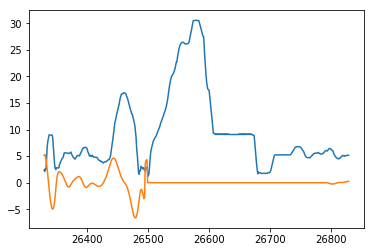

In [264]:
plt.plot(coordinatedf.index.get_level_values(level=0),coordinatedf[team,player,"S"]);
plt.plot(coordinatedf.index.get_level_values(level=0),coordinatedf[team,player,"A"]);

In [262]:
positions.loc[(slice(26480,26520)),(team,player,columns)]

TeamId                                 DFL-CLU-000N8Y                       \
PersonId                               DFL-OBJ-0027G6                        
Position                                            A      S      X      Y   
N     T                                                                      
26480 2019-06-11 20:58:00.800000+02:00          -6.48   8.51  34.97  23.54   
26481 2019-06-11 20:58:00.840000+02:00          -6.15   6.34  35.01  23.46   
26482 2019-06-11 20:58:00.880000+02:00          -5.64   5.21  35.03  23.41   
26483 2019-06-11 20:58:00.920000+02:00          -4.94   3.50  35.05  23.36   
26484 2019-06-11 20:58:00.960000+02:00          -4.09   1.97  35.04  23.33   
26485 2019-06-11 20:58:01+02:00                 -3.16   1.58  35.03  23.31   
26486 2019-06-11 20:58:01.040000+02:00          -2.25   2.29  35.01  23.29   
26487 2019-06-11 20:58:01.080000+02:00          -1.59   2.29  34.99  23.29   
26488 2019-06-11 20:58:01.120000+02:00          -1.27   3.10  34.95  23.31   
26489 2019-06-11 20:58:01.160000+02:00          -1.30   2.96  34.92  23.32   
26490 2019-06-11 20:58:01.200000+02:00          -1.60   2.80  34.89  23.34   
26491 2019-06-11 20:58:01.240000+02:00          -2.06   2.58  34.84  23.36   
26492 2019-06-11 20:58:01.280000+02:00          -2.54   2.80  34.81  23.38   
26493 2019-06-11 20:58:01.320000+02:00          -2.99   2.80  34.77  23.40   
26494 2019-06-11 20:58:01.360000+02:00          -2.64   2.24  34.72  23.42   
26495 2019-06-11 20:58:01.400000+02:00           3.40   2.48  34.69  23.43   
26496 2019-06-11 20:58:01.440000+02:00           4.07   2.60  34.65  23.44   
26497 2019-06-11 20:58:01.480000+02:00           4.28   2.78  34.64  23.45   
26498 2019-06-11 20:58:01.520000+02:00           4.32   2.96  34.63  23.46   
26499 2019-06-11 20:58:01.560000+02:00           0.00   1.79  34.63  23.47   
26500 2019-06-11 20:58:01.600000+02:00           0.00   1.25  34.65  23.47   
26501 2019-06-11 20:58:01.640000+02:00           0.00   1.64  34.69  23.48   
26502 2019-06-11 20:58:01.680000+02:00           0.00   2.96  34.74  23.50   
26503 2019-06-11 20:58:01.720000+02:00           0.00   4.31  34.80  23.50   
26504 2019-06-11 20:58:01.760000+02:00           0.00   5.71  34.87  23.50   
26505 2019-06-11 20:58:01.800000+02:00           0.00   6.32  34.94  23.50   
26506 2019-06-11 20:58:01.840000+02:00           0.00   6.80  35.02  23.49   
26507 2019-06-11 20:58:01.880000+02:00           0.00   7.33  35.10  23.46   
26508 2019-06-11 20:58:01.920000+02:00           0.00   7.73  35.18  23.43   
26509 2019-06-11 20:58:01.960000+02:00           0.00   8.00  35.26  23.40   
26510 2019-06-11 20:58:02+02:00                  0.00   8.25  35.35  23.37   
26511 2019-06-11 20:58:02.040000+02:00           0.00   8.46  35.44  23.34   
26512 2019-06-11 20:58:02.080000+02:00           0.00   8.64  35.53  23.29   
26513 2019-06-11 20:58:02.120000+02:00           0.00   8.81  35.62  23.25   
26514 2019-06-11 20:58:02.160000+02:00           0.00   9.13  35.71  23.21   
26515 2019-06-11 20:58:02.200000+02:00           0.00   9.40  35.81  23.18   
26516 2019-06-11 20:58:02.240000+02:00           0.00   9.74  35.90  23.14   
26517 2019-06-11 20:58:02.280000+02:00           0.00  10.03  36.00  23.07   
26518 2019-06-11 20:58:02.320000+02:00           0.00  10.32  36.10  23.00   
26519 2019-06-11 20:58:02.360000+02:00           0.00  10.62  36.20  22.93   
26520 2019-06-11 20:58:02.400000+02:00           0.00  11.06  36.30  22.87   

TeamId                                            
PersonId                                          
Position                                     DtB  
N     T                                           
26480 2019-06-11 20:58:00.800000+02:00  8.886225  
26481 2019-06-11 20:58:00.840000+02:00  8.811640  
26482 2019-06-11 20:58:00.880000+02:00  8.758641  
26483 2019-06-11 20:58:00.920000+02:00  8.704045  
26484 2019-06-11 20:58:00.960000+02:00  8.650000  
26485 2019-06-11 20:58:01+02:0

2. Halbzeit

In [25]:
positions2=get_tracking_data(xml_positions,"secondHalf")    

In [27]:
subs=kpimergednew[kpimergednew.SUBTYPE=='Substitution']

In [55]:
i=1
subs.index.tolist() ##eintrag in kpimerged
subs.loc[subs.index.tolist()[i],["PUID1","PUID2","N"]]

PUID1    DFL-OBJ-0000OJ
PUID2    DFL-OBJ-0000Q9
N                110968
Name: 1023, dtype: object

In [57]:
subs.loc[subs.index.tolist()[i],["PUID1"]].iat[0] in cuid1players

True

In [65]:
def getplayername(playerid):
    if playerid in cuid1_player_IDs:
        name=cuid1_team_meta_df["Name"][cuid1_team_meta_df["ObjectId"]==playerid]
    else:
        name=cuid2_team_meta_df["Name"][cuid2_team_meta_df["ObjectId"]==playerid]
    return name

In [88]:
calculateDistance2(positions2.loc[(111991),(CUID1,"DFL-OBJ-0000OJ","X")].iat[0],positions2.loc[(111991),(CUID1,"DFL-OBJ-0000OJ","Y")].iat[0],positions2.loc[(111992),(CUID1,"DFL-OBJ-0000OJ","X")].iat[0],positions2.loc[(111992),(CUID1,"DFL-OBJ-0000OJ","Y")].iat[0])

nan

In [89]:
np.isnan(positions2.loc[(111991),(CUID1,"DFL-OBJ-0001F4","X")].iat[0])==True

False

In [26]:
#calculates distance to ball for every player playing 2.half
players=positions2.columns.get_level_values(level=1).unique()
for player in players:
    if player in cuid1_player_IDs:
        positions2[CUID1,player,'DtB']=positions2.apply(lambda x: calculateDistance(x[CUID1,player,'X'],x[CUID1,player,'Y'],x['BALL','DFL-OBJ-0000XT','X'],x['BALL','DFL-OBJ-0000XT','Y']),axis=1)
    if player in cuid2_player_IDs:
        positions2[CUID2,player,'DtB']=positions2.apply(lambda x: calculateDistance(x[CUID2,player,'X'],x[CUID2,player,'Y'],x['BALL','DFL-OBJ-0000XT','X'],x['BALL','DFL-OBJ-0000XT','Y']),axis=1)

In [210]:
(balldf2.loc[:,("BALL","DFL-OBJ-0000XT","BallStatus")]==1).sum()

46497

In [35]:
def possession(teamid,half,style):
    
    if style=="standard":
        #anz=((balldf2.loc[:,("BALL","DFL-OBJ-0000XT","BallStatus")]==1) & (balldf2.loc[:,("BALL","DFL-OBJ-0000XT","BallPossession")]==1) & (balldf2.loc[:,("BALL","DFL-OBJ-0000XT","X")]>=0)).sum()
        anz=((matchinfo.get(half)["BallDf"].loc[:,("BALL","DFL-OBJ-0000XT","BallPossession")]==matchinfo.get(teamid)["BallPoss"])).sum()
        ges=len(matchinfo.get(half)["BallDf"].loc[:,("BALL","DFL-OBJ-0000XT","BallPossession")])
        poss=anz/ges
        minutes= anz/1500
        
    if style=="cleaned standard":
        anz=((matchinfo.get(half)["BallDf"].loc[:,("BALL","DFL-OBJ-0000XT","BallPossession")]==matchinfo.get(teamid)["BallPoss"]) & (matchinfo.get(half)["BallDf"].loc[:,("BALL","DFL-OBJ-0000XT","BallStatus")]==1)).sum()
        ges=((matchinfo.get(half)["BallDf"].loc[:,("BALL","DFL-OBJ-0000XT","BallStatus")]==1)).sum()
        poss=anz/ges
        minutes= anz/1500
        
    if style=="opposing half":
        if matchinfo.get(teamid)[half]=="left to right":
            #anz=((balldf2.loc[:,("BALL","DFL-OBJ-0000XT","BallStatus")]==1) & (balldf2.loc[:,("BALL","DFL-OBJ-0000XT","BallPossession")]==1) & (balldf2.loc[:,("BALL","DFL-OBJ-0000XT","X")]>=0)).sum()
            anz=((matchinfo.get(half)["BallDf"].loc[:,("BALL","DFL-OBJ-0000XT","BallPossession")]==matchinfo.get(teamid)["BallPoss"]) & (matchinfo.get(half)["BallDf"].loc[:,("BALL","DFL-OBJ-0000XT","X")]>=0)).sum()
            ges=((matchinfo.get(half)["BallDf"].loc[:,("BALL","DFL-OBJ-0000XT","BallPossession")]==matchinfo.get(teamid)["BallPoss"])).sum()
            poss=anz/ges
            minutes= anz/1500
        if matchinfo.get(teamid)[half]=="right to left":
            anz=((matchinfo.get(half)["BallDf"].loc[:,("BALL","DFL-OBJ-0000XT","BallPossession")]==matchinfo.get(teamid)["BallPoss"]) & (matchinfo.get(half)["BallDf"].loc[:,("BALL","DFL-OBJ-0000XT","X")]<=0)).sum()
            ges=((matchinfo.get(half)["BallDf"].loc[:,("BALL","DFL-OBJ-0000XT","BallPossession")]==matchinfo.get(teamid)["BallPoss"])).sum()
            poss=anz/ges
            minutes= anz/1500

    return poss,minutes

In [137]:
##combine 
typeofposs="cleaned standard"
teamid=CUID2
(possession(teamid,1,typeofposs)[0] + possession(teamid,2,typeofposs)[0])/2       #ballpossession 
#(possession(CUID1,1,typeofposs)[1] + possession(CUID1,2,typeofposs)[1])+(possession(CUID2,1,typeofposs)[1] + possession(CUID2,2,typeofposs)[1])       #playing minutes

0.26549264551393725

In [91]:
possession(CUID1,2,"classic")

0.5847659574468085

In [87]:
matchinfo.get(1)["BallDf"].loc[:,("BALL","DFL-OBJ-0000XT","BallPossession")]

N      T                               
10000  2019-06-11 20:47:01.600000+02:00    1
10001  2019-06-11 20:47:01.640000+02:00    1
10002  2019-06-11 20:47:01.680000+02:00    1
10003  2019-06-11 20:47:01.720000+02:00    1
10004  2019-06-11 20:47:01.760000+02:00    1
10005  2019-06-11 20:47:01.800000+02:00    1
10006  2019-06-11 20:47:01.840000+02:00    1
10007  2019-06-11 20:47:01.880000+02:00    1
10008  2019-06-11 20:47:01.920000+02:00    1
10009  2019-06-11 20:47:01.960000+02:00    1
10010  2019-06-11 20:47:02+02:00           1
10011  2019-06-11 20:47:02.040000+02:00    1
10012  2019-06-11 20:47:02.080000+02:00    1
10013  2019-06-11 20:47:02.120000+02:00    1
10014  2019-06-11 20:47:02.160000+02:00    1
10015  2019-06-11 20:47:02.200000+02:00    1
10016  2019-06-11 20:47:02.240000+02:00    1
10017  2019-06-11 20:47:02.280000+02:00    1
10018  2019-06-11 20:47:02.320000+02:00    1
10019  2019-06-11 20:47:02.360000+02:00    1
10020  2019-06-11 20:47:02.400000+02:00    1
10021  2019-06-

In [50]:
len(balldf2.loc[:,("BALL","DFL-OBJ-0000XT","BallPossession")])

70500

# GER - EST

In [94]:
xml_positions = etree.parse('C:/Users/Tim/Desktop/Q-Index Master/data/GER-EST/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-003BEU.xml') ##privat
kpimerged = pd.read_excel('C:/Users/Tim/Desktop/Q-Index Master/data/GER-EST/DFB_KPI_MERGED.xlsx') #arbeit
path='C:/Users/Tim/Desktop/Q-Index Master/data/GER-EST/'  
kpimergednew = kpimerged.rename({'FRAME_NUMBER': 'N'}, axis=1)
positions=get_tracking_data(xml_positions)     
##create dataframe from xml input
positions2=get_tracking_data(xml_positions,"secondHalf")  

In [95]:
CUID1 = 'DFL-CLU-000N8Y'  #Deutschland
CUID2 = 'DFL-CLU-000N8Z'  #Estland

In [96]:
matchinfo = {
    CUID1: {
        "BallPoss":1,
        "TeamID":CUID1,
    },
    CUID2: {
        "BallPoss":2,
        "TeamID":CUID2,
    },
    1: {
        "Dataframe":positions,
    },
    2: {
        "Dataframe":positions2,
    }
}

In [97]:
matchinfo = {
    CUID1: {
        1:getdirectionofplay(CUID1,1),
        2:getdirectionofplay(CUID1,2),
        "BallPoss":1,
        "TeamID":CUID1,
    },
    CUID2: {
        1:getdirectionofplay(CUID2,1),
        2:getdirectionofplay(CUID2,2),
        "BallPoss":2,
        "TeamID":CUID2,
    },
    1: {
        "Dataframe":positions,
        CUID1:getteamsheet(CUID1,1),
        CUID2:getteamsheet(CUID2,1),
        "Startframe":positions.index.get_level_values(0)[0],
        "Endframe":positions.index.get_level_values(0)[positions.shape[0]-1],
    },
    2: {
        "Dataframe":positions2,
        CUID1:getteamsheet(CUID1,2),
        CUID2:getteamsheet(CUID2,2),
        "Startframe":positions2.index.get_level_values(0)[0],
        "Endframe":positions2.index.get_level_values(0)[positions.shape[0]-1],
    },
    "left to right":{
        "Goalline":52.5
    },
    "right to left":{
        "Goalline":-52.5
    }
}

In [98]:
players=positions.columns.get_level_values(level=1).unique()
players=players.append(positions2.columns.get_level_values(level=1).unique())
players=players.unique()
players=players.drop("DFL-OBJ-0000XT")
players
for player in players:
    if player in matchinfo.get(1)[CUID1]:
        positions[CUID1,player,'DtB']=positions.apply(lambda x: calculateDistance(x[CUID1,player,'X'],x[CUID1,player,'Y'],x['BALL','DFL-OBJ-0000XT','X'],x['BALL','DFL-OBJ-0000XT','Y']),axis=1)
    if player in matchinfo.get(1)[CUID2]:
        positions[CUID2,player,'DtB']=positions.apply(lambda x: calculateDistance(x[CUID2,player,'X'],x[CUID2,player,'Y'],x['BALL','DFL-OBJ-0000XT','X'],x['BALL','DFL-OBJ-0000XT','Y']),axis=1)

In [99]:
for player in players:
    if player in matchinfo.get(2)[CUID1]:
        positions2[CUID1,player,'DtB']=positions2.apply(lambda x: calculateDistance(x[CUID1,player,'X'],x[CUID1,player,'Y'],x['BALL','DFL-OBJ-0000XT','X'],x['BALL','DFL-OBJ-0000XT','Y']),axis=1)
    if player in matchinfo.get(2)[CUID2]:
        positions2[CUID2,player,'DtB']=positions2.apply(lambda x: calculateDistance(x[CUID2,player,'X'],x[CUID2,player,'Y'],x['BALL','DFL-OBJ-0000XT','X'],x['BALL','DFL-OBJ-0000XT','Y']),axis=1)

In [100]:
balldf=positions.loc[:,("BALL","DFL-OBJ-0000XT",slice(None))]   ##Ballkoordinaten 1. Halbzeit
CUID1df = positions.loc[:,(CUID1,slice(None),slice(None))]     ##Koordinaten von CUID1 1. Halbzeit
cuid1players=CUID1df.columns.get_level_values(level=1).unique()        ##Spieler, die in der 1. Halbzeit auf dem Platz standen
cuid1balldf=pd.merge(CUID1df, balldf, left_index=True, right_index=True)  

CUID2df = positions.loc[:,(CUID2,slice(None),slice(None))]     ##Koordinaten von CUID2 1. Halbzeit
cuid2players=CUID2df.columns.get_level_values(level=1).unique()        ##Spieler, die in der 1. Halbzeit auf dem Platz standen
cuid2balldf=pd.merge(CUID2df, balldf, left_index=True, right_index=True)   ##Gemergter Dataframe Ball und CUID1 1. Halbzeit

balldf2=positions2.loc[:,("BALL","DFL-OBJ-0000XT",slice(None))]   ##Ballkoordinaten 2. Halbzeit
CUID1df2 = positions2.loc[:,(CUID1,slice(None),slice(None))]     ##Koordinaten von CUID1 2. Halbzeit
cuid1players2=CUID1df2.columns.get_level_values(level=1).unique()        ##Spieler, die in der 2. Halbzeit auf dem Platz standen
cuid1balldf2=pd.merge(CUID1df2, balldf2, left_index=True, right_index=True)   ##Gemergter Dataframe Ball und CUID1 2. Halbzeit

CUID2df2 = positions2.loc[:,(CUID2,slice(None),slice(None))]     ##Koordinaten von CUID1 1. Halbzeit
cuid2players2=CUID2df2.columns.get_level_values(level=1).unique()        ##Spieler, die in der 1. Halbzeit auf dem Platz standen
cuid2balldf2=pd.merge(CUID2df2, balldf2, left_index=True, right_index=True)   ##Gemergter Dataframe Ball und CUID1 1. Halbzeit

In [101]:
matchinfo = {
    CUID1: {
        1:getdirectionofplay(CUID1,1),
        2:getdirectionofplay(CUID1,2),
        "BallPoss":1,
        "TeamID":CUID1,
        "TeamBallDf1":cuid1balldf,
        "TeamBallDf2":cuid1balldf2,
    },
    CUID2: {
        1:getdirectionofplay(CUID2,1),
        2:getdirectionofplay(CUID2,2),
        "BallPoss":2,
        "TeamID":CUID2,
        "TeamBallDf1":cuid2balldf,
        "TeamBallDf2":cuid2balldf2,
    },
    1: {
        "BallDf":balldf,
        "Dataframe":positions,
        CUID1:getteamsheet(CUID1,1),
        CUID2:getteamsheet(CUID2,1),
        "Startframe":positions.index.get_level_values(0)[0],
        "Endframe":positions.index.get_level_values(0)[positions.shape[0]-1],
    },
    2: {
        "BallDf":balldf2,
        "Dataframe":positions2,
        CUID1:getteamsheet(CUID1,2),
        CUID2:getteamsheet(CUID2,2),
        "Startframe":positions2.index.get_level_values(0)[0],
        "Endframe":positions2.index.get_level_values(0)[positions.shape[0]-1],
    },
    "left to right":{
        "Goalline":52.5
    },
    "right to left":{
        "Goalline":-52.5
    }
}

In [102]:
##combine 
typeofposs="cleaned standard"
teamid=CUID1
(possession(teamid,1,typeofposs)[0] + possession(teamid,2,typeofposs)[0])/2       #ballpossession 
#(possession(CUID1,1,typeofposs)[1] + possession(CUID1,2,typeofposs)[1])+(possession(CUID2,1,typeofposs)[1] + possession(CUID2,2,typeofposs)[1])       #playing minutes

0.7345073544860627

In [103]:
##combine 
typeofposs="cleaned standard"
teamid=CUID2
(possession(teamid,1,typeofposs)[0] + possession(teamid,2,typeofposs)[0])/2       #ballpossession 
#(possession(CUID1,1,typeofposs)[1] + possession(CUID1,2,typeofposs)[1])+(possession(CUID2,1,typeofposs)[1] + possession(CUID2,2,typeofposs)[1])       #playing minutes

0.26549264551393725

In [104]:
##combine 
typeofposs="opposing half"
teamid=CUID1
(possession(teamid,1,typeofposs)[0] + possession(teamid,2,typeofposs)[0])/2       #ballpossession 
#(possession(CUID1,1,typeofposs)[1] + possession(CUID1,2,typeofposs)[1])+(possession(CUID2,1,typeofposs)[1] + possession(CUID2,2,typeofposs)[1])       #playing minutes

0.7910000114490274

In [105]:
##combine 
typeofposs="opposing half"
teamid=CUID2
(possession(teamid,1,typeofposs)[0] + possession(teamid,2,typeofposs)[0])/2       #ballpossession 
#(possession(CUID1,1,typeofposs)[1] + possession(CUID1,2,typeofposs)[1])+(possession(CUID2,1,typeofposs)[1] + possession(CUID2,2,typeofposs)[1])       #playing minutes

0.14522744162737847

In [106]:
###Zusammenspiel aller Codeschnipsel für alle Spieler
numofsprints=0
for player in matchinfo.get(1)[CUID1]:
    currentdf=createsprintdf2(1,CUID1,player,4,17.5,1)
    indexNames = currentdf[ currentdf['Adj Endframe']-currentdf['Startframe'] < 10 ].index
    currentdf.drop(indexNames , inplace=True)
    numofsprints=numofsprints+len(currentdf[(currentdf.BP=="Yes") & (currentdf.FinalThird=="Yes") & (currentdf.Poss=="No")& (currentdf.Forward=="Yes")].index)
print(numofsprints)

73


In [107]:
numofsprints=0
for player in matchinfo.get(2)[CUID1]:
    currentdf=createsprintdf2(2,CUID1,player,4,17.5,1)
    indexNames = currentdf[ currentdf['Adj Endframe']-currentdf['Startframe'] < 10 ].index
    currentdf.drop(indexNames , inplace=True)
    numofsprints=numofsprints+len(currentdf[(currentdf.BP=="Yes") & (currentdf.FinalThird=="Yes") & (currentdf.Poss=="No")& (currentdf.Forward=="Yes")].index)
print(numofsprints)

77


In [108]:
###Zusammenspiel aller Codeschnipsel für alle Spieler
numofsprints=0
for player in matchinfo.get(1)[CUID2]:
    currentdf=createsprintdf2(1,CUID2,player,4,17.5,1)
    indexNames = currentdf[ currentdf['Adj Endframe']-currentdf['Startframe'] < 10 ].index
    currentdf.drop(indexNames , inplace=True)
    numofsprints=numofsprints+len(currentdf[(currentdf.BP=="Yes") & (currentdf.FinalThird=="Yes") & (currentdf.Poss=="No")& (currentdf.Forward=="Yes")].index)
print(numofsprints)

4


In [109]:
###Zusammenspiel aller Codeschnipsel für alle Spieler
numofsprints=0
for player in matchinfo.get(2)[CUID2]:
    currentdf=createsprintdf2(2,CUID2,player,4,17.5,1)
    indexNames = currentdf[ currentdf['Adj Endframe']-currentdf['Startframe'] < 10 ].index
    currentdf.drop(indexNames , inplace=True)
    numofsprints=numofsprints+len(currentdf[(currentdf.BP=="Yes") & (currentdf.FinalThird=="Yes") & (currentdf.Poss=="No")& (currentdf.Forward=="Yes")].index)
print(numofsprints)

3


# GER -NED

In [43]:
xml_positions = etree.parse('C:/Users/Jung/Desktop/Q-Index Master/data/GER-NED/DFL_04_02_positions_raw_DFL-COM-000001_DFL-MAT-X03BWS.xml') ##arbeitsplatop
kpimerged = pd.read_excel('C:/Users/Jung/Desktop/Q-Index Master/data/GER-NED/KPI_MERGED.xlsx') #arbeit
path='C:/Users/Jung/Desktop/Q-Index Master/data/GER-NED/'    #arbeit

OSError: Error reading file 'C:/Users/Jung/Desktop/Q-Index Master/data/GER-NED/DFL_04_02_positions_raw_DFL-COM-000001_DFL-MAT-X03BWS.xml': failed to load external entity "file:/C:/Users/Jung/Desktop/Q-Index%20Master/data/GER-NED/DFL_04_02_positions_raw_DFL-COM-000001_DFL-MAT-X03BWS.xml"

In [42]:
kpimergednew = kpimerged.rename({'FRAME_NUMBER': 'N'}, axis=1)
positions=get_tracking_data(xml_positions)     
##create dataframe from xml input
positions2=get_tracking_data(xml_positions,"secondHalf")  

OSError: Error reading file 'C:/Users/Jung/Desktop/Q-Index Master/data/GER-NED/DFL_04_02_positions_raw_DFL-COM-000001_DFL-MAT-X03BWS.xml': failed to load external entity "file:/C:/Users/Jung/Desktop/Q-Index%20Master/data/GER-NED/DFL_04_02_positions_raw_DFL-COM-000001_DFL-MAT-X03BWS.xml"

In [44]:
xml_positions = etree.parse('C:/Users/Tim/Desktop/Q-Index Master/data/GER-NED/DFL_04_02_positions_raw_DFL-COM-000001_DFL-MAT-X03BWS.xml') ##privat
kpimerged = pd.read_excel('C:/Users/Tim/Desktop/Q-Index Master/data/GER-NED/KPI_MERGED.xlsx') #arbeit
path='C:/Users/Tim/Desktop/Q-Index Master/data/GER-NED/'  
kpimergednew = kpimerged.rename({'FRAME_NUMBER': 'N'}, axis=1)
positions=get_tracking_data(xml_positions)     
##create dataframe from xml input
positions2=get_tracking_data(xml_positions,"secondHalf")  

In [53]:
CUID1 = 'DFL-CLU-000N9A'  #Niederlande
CUID2 = 'DFL-CLU-000N99'  #Deutschland

In [56]:
matchinfo = {
    CUID1: {
        "BallPoss":1,
        "TeamID":CUID1,
    },
    CUID2: {
        "BallPoss":2,
        "TeamID":CUID2,
    },
    1: {
        "Dataframe":positions,
    },
    2: {
        "Dataframe":positions2,
    }
}

In [58]:
matchinfo = {
    CUID1: {
        1:getdirectionofplay(CUID1,1),
        2:getdirectionofplay(CUID1,2),
        "BallPoss":1,
        "TeamID":CUID1,
    },
    CUID2: {
        1:getdirectionofplay(CUID2,1),
        2:getdirectionofplay(CUID2,2),
        "BallPoss":2,
        "TeamID":CUID2,
    },
    1: {
        "Dataframe":positions,
        CUID1:getteamsheet(CUID1,1),
        CUID2:getteamsheet(CUID2,1),
        "Startframe":positions.index.get_level_values(0)[0],
        "Endframe":positions.index.get_level_values(0)[positions.shape[0]-1],
    },
    2: {
        "Dataframe":positions2,
        CUID1:getteamsheet(CUID1,2),
        CUID2:getteamsheet(CUID2,2),
        "Startframe":positions2.index.get_level_values(0)[0],
        "Endframe":positions2.index.get_level_values(0)[positions.shape[0]-1],
    },
    "left to right":{
        "Goalline":52.5
    },
    "right to left":{
        "Goalline":-52.5
    }
}

In [59]:
players=positions.columns.get_level_values(level=1).unique()
players=players.append(positions2.columns.get_level_values(level=1).unique())
players=players.unique()
players=players.drop("DFL-OBJ-0000XT")
players
for player in players:
    if player in matchinfo.get(1)[CUID1]:
        positions[CUID1,player,'DtB']=positions.apply(lambda x: calculateDistance(x[CUID1,player,'X'],x[CUID1,player,'Y'],x['BALL','DFL-OBJ-0000XT','X'],x['BALL','DFL-OBJ-0000XT','Y']),axis=1)
    if player in matchinfo.get(1)[CUID2]:
        positions[CUID2,player,'DtB']=positions.apply(lambda x: calculateDistance(x[CUID2,player,'X'],x[CUID2,player,'Y'],x['BALL','DFL-OBJ-0000XT','X'],x['BALL','DFL-OBJ-0000XT','Y']),axis=1)

In [61]:
for player in players:
    if player in matchinfo.get(2)[CUID1]:
        positions2[CUID1,player,'DtB']=positions2.apply(lambda x: calculateDistance(x[CUID1,player,'X'],x[CUID1,player,'Y'],x['BALL','DFL-OBJ-0000XT','X'],x['BALL','DFL-OBJ-0000XT','Y']),axis=1)
    if player in matchinfo.get(2)[CUID2]:
        positions2[CUID2,player,'DtB']=positions2.apply(lambda x: calculateDistance(x[CUID2,player,'X'],x[CUID2,player,'Y'],x['BALL','DFL-OBJ-0000XT','X'],x['BALL','DFL-OBJ-0000XT','Y']),axis=1)

In [62]:
balldf=positions.loc[:,("BALL","DFL-OBJ-0000XT",slice(None))]   ##Ballkoordinaten 1. Halbzeit
CUID1df = positions.loc[:,(CUID1,slice(None),slice(None))]     ##Koordinaten von CUID1 1. Halbzeit
cuid1players=CUID1df.columns.get_level_values(level=1).unique()        ##Spieler, die in der 1. Halbzeit auf dem Platz standen
cuid1balldf=pd.merge(CUID1df, balldf, left_index=True, right_index=True)  

In [63]:
CUID2df = positions.loc[:,(CUID2,slice(None),slice(None))]     ##Koordinaten von CUID2 1. Halbzeit
cuid2players=CUID2df.columns.get_level_values(level=1).unique()        ##Spieler, die in der 1. Halbzeit auf dem Platz standen
cuid2balldf=pd.merge(CUID2df, balldf, left_index=True, right_index=True)   ##Gemergter Dataframe Ball und CUID1 1. Halbzeit

In [64]:
balldf2=positions2.loc[:,("BALL","DFL-OBJ-0000XT",slice(None))]   ##Ballkoordinaten 2. Halbzeit
CUID1df2 = positions2.loc[:,(CUID1,slice(None),slice(None))]     ##Koordinaten von CUID1 2. Halbzeit
cuid1players2=CUID1df2.columns.get_level_values(level=1).unique()        ##Spieler, die in der 2. Halbzeit auf dem Platz standen
cuid1balldf2=pd.merge(CUID1df2, balldf2, left_index=True, right_index=True)   ##Gemergter Dataframe Ball und CUID1 2. Halbzeit

In [65]:
CUID2df2 = positions2.loc[:,(CUID2,slice(None),slice(None))]     ##Koordinaten von CUID1 1. Halbzeit
cuid2players2=CUID2df2.columns.get_level_values(level=1).unique()        ##Spieler, die in der 1. Halbzeit auf dem Platz standen
cuid2balldf2=pd.merge(CUID2df2, balldf2, left_index=True, right_index=True)   ##Gemergter Dataframe Ball und CUID1 1. Halbzeit

In [66]:
matchinfo = {
    CUID1: {
        1:getdirectionofplay(CUID1,1),
        2:getdirectionofplay(CUID1,2),
        "BallPoss":1,
        "TeamID":CUID1,
        "TeamBallDf1":cuid1balldf,
        "TeamBallDf2":cuid1balldf2,
    },
    CUID2: {
        1:getdirectionofplay(CUID2,1),
        2:getdirectionofplay(CUID2,2),
        "BallPoss":2,
        "TeamID":CUID2,
        "TeamBallDf1":cuid2balldf,
        "TeamBallDf2":cuid2balldf2,
    },
    1: {
        "BallDf":balldf,
        "Dataframe":positions,
        CUID1:getteamsheet(CUID1,1),
        CUID2:getteamsheet(CUID2,1),
        "Startframe":positions.index.get_level_values(0)[0],
        "Endframe":positions.index.get_level_values(0)[positions.shape[0]-1],
    },
    2: {
        "BallDf":balldf2,
        "Dataframe":positions2,
        CUID1:getteamsheet(CUID1,2),
        CUID2:getteamsheet(CUID2,2),
        "Startframe":positions2.index.get_level_values(0)[0],
        "Endframe":positions2.index.get_level_values(0)[positions.shape[0]-1],
    },
    "left to right":{
        "Goalline":52.5
    },
    "right to left":{
        "Goalline":-52.5
    }
}

In [68]:
##combine 
typeofposs="cleaned standard"
teamid=CUID1
(possession(teamid,1,typeofposs)[0] + possession(teamid,2,typeofposs)[0])/2       #ballpossession 
#(possession(CUID1,1,typeofposs)[1] + possession(CUID1,2,typeofposs)[1])+(possession(CUID2,1,typeofposs)[1] + possession(CUID2,2,typeofposs)[1])       #playing minutes

0.4530420620805543

In [67]:
##combine 
typeofposs="cleaned standard"
teamid=CUID2
(possession(teamid,1,typeofposs)[0] + possession(teamid,2,typeofposs)[0])/2       #ballpossession 
#(possession(CUID1,1,typeofposs)[1] + possession(CUID1,2,typeofposs)[1])+(possession(CUID2,1,typeofposs)[1] + possession(CUID2,2,typeofposs)[1])       #playing minutes

0.5469579379194457

In [69]:
##combine 
typeofposs="opposing half"
teamid=CUID1
(possession(teamid,1,typeofposs)[0] + possession(teamid,2,typeofposs)[0])/2       #ballpossession 
#(possession(CUID1,1,typeofposs)[1] + possession(CUID1,2,typeofposs)[1])+(possession(CUID2,1,typeofposs)[1] + possession(CUID2,2,typeofposs)[1])       #playing minutes

0.6001491704820834

In [70]:
##combine 
typeofposs="opposing half"
teamid=CUID2
(possession(teamid,1,typeofposs)[0] + possession(teamid,2,typeofposs)[0])/2       #ballpossession 
#(possession(CUID1,1,typeofposs)[1] + possession(CUID1,2,typeofposs)[1])+(possession(CUID2,1,typeofposs)[1] + possession(CUID2,2,typeofposs)[1])       #playing minutes

0.4861773863857116

In [71]:
###Zusammenspiel aller Codeschnipsel für alle Spieler
numofsprints=0
for player in matchinfo.get(1)[CUID1]:
    currentdf=createsprintdf2(1,CUID1,player,4,17.5,1)
    indexNames = currentdf[ currentdf['Adj Endframe']-currentdf['Startframe'] < 10 ].index
    currentdf.drop(indexNames , inplace=True)
    numofsprints=numofsprints+len(currentdf[(currentdf.BP=="Yes") & (currentdf.FinalThird=="Yes") & (currentdf.Poss=="No")& (currentdf.Forward=="Yes")].index)
print(numofsprints)

21


In [72]:
numofsprints=0
for player in matchinfo.get(2)[CUID1]:
    currentdf=createsprintdf2(2,CUID1,player,4,17.5,1)
    indexNames = currentdf[ currentdf['Adj Endframe']-currentdf['Startframe'] < 10 ].index
    currentdf.drop(indexNames , inplace=True)
    numofsprints=numofsprints+len(currentdf[(currentdf.BP=="Yes") & (currentdf.FinalThird=="Yes") & (currentdf.Poss=="No")& (currentdf.Forward=="Yes")].index)
print(numofsprints)

17


In [73]:
###Zusammenspiel aller Codeschnipsel für alle Spieler
numofsprints=0
for player in matchinfo.get(1)[CUID2]:
    currentdf=createsprintdf2(1,CUID2,player,4,17.5,1)
    indexNames = currentdf[ currentdf['Adj Endframe']-currentdf['Startframe'] < 10 ].index
    currentdf.drop(indexNames , inplace=True)
    numofsprints=numofsprints+len(currentdf[(currentdf.BP=="Yes") & (currentdf.FinalThird=="Yes") & (currentdf.Poss=="No")& (currentdf.Forward=="Yes")].index)
print(numofsprints)

5


In [297]:
###Zusammenspiel aller Codeschnipsel für alle Spieler
numofsprints=0
for player in matchinfo.get(2)[CUID2]:
    currentdf=createsprintdf2(2,CUID2,player,4,17.5,1)
    indexNames = currentdf[ currentdf['Adj Endframe']-currentdf['Startframe'] < 10 ].index
    currentdf.drop(indexNames , inplace=True)
    numofsprints=numofsprints+len(currentdf[(currentdf.BP=="Yes") & (currentdf.FinalThird=="Yes") & (currentdf.Poss=="No")& (currentdf.Forward=="Yes")].index)
print(numofsprints)

9


# GER - BEL U21

In [5]:
path='C:/Users/Jung/Desktop/Q-Index Master/data/GER-BEL/'    #arbeit
kpimerged = pd.read_excel('C:/Users/Jung/Desktop/Q-Index Master/data/GER-BEL/KPI_MERGED.xlsx') #arbeit
kpimergednew = kpimerged.rename({'FRAME_NUMBER': 'N'}, axis=1)

xml_positions = etree.parse('C:/Users/Jung/Desktop/Q-Index Master/data/GER-BEL/DFL_04_02_positions_raw_DFL-COM-000001_DFL-MAT-003BWT.xml') ##arbeitsplatop
positions=get_tracking_data(xml_positions)     
positions2=get_tracking_data(xml_positions,"secondHalf")     
##create dataframe from xml input

In [8]:
kpimergednew = kpimerged.rename({'FRAME_NUMBER': 'N'}, axis=1)
kpimergednew = kpimergednew.rename({'CUID1': 'CUID'}, axis=1)

In [9]:
CUID1 = 'DFL-CLU-000N9A' ##Deutschland
CUID2 = 'DFL-CLU-000N9B' ##Belgien

In [12]:
matchinfo = {
    CUID1: {
        "BallPoss":1,
        "TeamID":CUID1,
    },
    CUID2: {
        "BallPoss":2,
        "TeamID":CUID2,
    },
    1: {
        "Dataframe":positions,
    },
    2: {
        "Dataframe":positions2,
    }
}

In [13]:
matchinfo = {
    CUID1: {
        1:getdirectionofplay(CUID1,1),
        2:getdirectionofplay(CUID1,2),
        "BallPoss":1,
        "TeamID":CUID1,
    },
    CUID2: {
        1:getdirectionofplay(CUID2,1),
        2:getdirectionofplay(CUID2,2),
        "BallPoss":2,
        "TeamID":CUID2,
    },
    1: {
        "Dataframe":positions,
        CUID1:getteamsheet(CUID1,1),
        CUID2:getteamsheet(CUID2,1),
        "Startframe":positions.index.get_level_values(0)[0],
        "Endframe":positions.index.get_level_values(0)[positions.shape[0]-1],
    },
    2: {
        "Dataframe":positions2,
        CUID1:getteamsheet(CUID1,2),
        CUID2:getteamsheet(CUID2,2),
        "Startframe":positions2.index.get_level_values(0)[0],
        "Endframe":positions2.index.get_level_values(0)[positions.shape[0]-1],
    },
    "left to right":{
        "Goalline":52.5
    },
    "right to left":{
        "Goalline":-52.5
    }
}

In [28]:
players=positions.columns.get_level_values(level=1).unique()
players=players.append(positions2.columns.get_level_values(level=1).unique())
players=players.unique()
players=players.drop("DFL-OBJ-0000XT")
players
for player in players:
    if player in matchinfo.get(1)[CUID1]:
        positions[CUID1,player,'DtB']=positions.apply(lambda x: calculateDistance(x[CUID1,player,'X'],x[CUID1,player,'Y'],x['BALL','DFL-OBJ-0000XT','X'],x['BALL','DFL-OBJ-0000XT','Y']),axis=1)
    if player in matchinfo.get(1)[CUID2]:
        positions[CUID2,player,'DtB']=positions.apply(lambda x: calculateDistance(x[CUID2,player,'X'],x[CUID2,player,'Y'],x['BALL','DFL-OBJ-0000XT','X'],x['BALL','DFL-OBJ-0000XT','Y']),axis=1)

In [29]:
for player in players:
    if player in matchinfo.get(2)[CUID1]:
        positions2[CUID1,player,'DtB']=positions2.apply(lambda x: calculateDistance(x[CUID1,player,'X'],x[CUID1,player,'Y'],x['BALL','DFL-OBJ-0000XT','X'],x['BALL','DFL-OBJ-0000XT','Y']),axis=1)
    if player in matchinfo.get(2)[CUID2]:
        positions2[CUID2,player,'DtB']=positions2.apply(lambda x: calculateDistance(x[CUID2,player,'X'],x[CUID2,player,'Y'],x['BALL','DFL-OBJ-0000XT','X'],x['BALL','DFL-OBJ-0000XT','Y']),axis=1)

In [30]:
balldf=positions.loc[:,("BALL","DFL-OBJ-0000XT",slice(None))]   ##Ballkoordinaten 1. Halbzeit
CUID1df = positions.loc[:,(CUID1,slice(None),slice(None))]     ##Koordinaten von CUID1 1. Halbzeit
cuid1players=CUID1df.columns.get_level_values(level=1).unique()        ##Spieler, die in der 1. Halbzeit auf dem Platz standen
cuid1balldf=pd.merge(CUID1df, balldf, left_index=True, right_index=True)  

In [31]:
CUID2df = positions.loc[:,(CUID2,slice(None),slice(None))]     ##Koordinaten von CUID2 1. Halbzeit
cuid2players=CUID2df.columns.get_level_values(level=1).unique()        ##Spieler, die in der 1. Halbzeit auf dem Platz standen
cuid2balldf=pd.merge(CUID2df, balldf, left_index=True, right_index=True)   ##Gemergter Dataframe Ball und CUID1 1. Halbzeit

In [32]:
balldf2=positions2.loc[:,("BALL","DFL-OBJ-0000XT",slice(None))]   ##Ballkoordinaten 2. Halbzeit
CUID1df2 = positions2.loc[:,(CUID1,slice(None),slice(None))]     ##Koordinaten von CUID1 2. Halbzeit
cuid1players2=CUID1df2.columns.get_level_values(level=1).unique()        ##Spieler, die in der 2. Halbzeit auf dem Platz standen
cuid1balldf2=pd.merge(CUID1df2, balldf2, left_index=True, right_index=True)   ##Gemergter Dataframe Ball und CUID1 2. Halbzeit

In [33]:
CUID2df2 = positions2.loc[:,(CUID2,slice(None),slice(None))]     ##Koordinaten von CUID1 1. Halbzeit
cuid2players2=CUID2df2.columns.get_level_values(level=1).unique()        ##Spieler, die in der 1. Halbzeit auf dem Platz standen
cuid2balldf2=pd.merge(CUID2df2, balldf2, left_index=True, right_index=True)   ##Gemergter Dataframe Ball und CUID1 1. Halbzeit

In [34]:
matchinfo = {
    CUID1: {
        1:getdirectionofplay(CUID1,1),
        2:getdirectionofplay(CUID1,2),
        "BallPoss":1,
        "TeamID":CUID1,
        "TeamBallDf1":cuid1balldf,
        "TeamBallDf2":cuid1balldf2,
    },
    CUID2: {
        1:getdirectionofplay(CUID2,1),
        2:getdirectionofplay(CUID2,2),
        "BallPoss":2,
        "TeamID":CUID2,
        "TeamBallDf1":cuid2balldf,
        "TeamBallDf2":cuid2balldf2,
    },
    1: {
        "BallDf":balldf,
        "Dataframe":positions,
        CUID1:getteamsheet(CUID1,1),
        CUID2:getteamsheet(CUID2,1),
        "Startframe":positions.index.get_level_values(0)[0],
        "Endframe":positions.index.get_level_values(0)[positions.shape[0]-1],
    },
    2: {
        "BallDf":balldf2,
        "Dataframe":positions2,
        CUID1:getteamsheet(CUID1,2),
        CUID2:getteamsheet(CUID2,2),
        "Startframe":positions2.index.get_level_values(0)[0],
        "Endframe":positions2.index.get_level_values(0)[positions.shape[0]-1],
    },
    "left to right":{
        "Goalline":52.5
    },
    "right to left":{
        "Goalline":-52.5
    }
}

Die Ballbesitz Statistik wird im folgenden Abschnitt erzeugt. 
"Standard" - Ballbesitz ohne Berücksichtigung 
"Cleaned Standard" - Netto Ballbesitz
"Opposing Half" - Anteil des eigenen Ballbesitzes in der gegnerischen Hälfte

In [39]:
##combine 
typeofposs="cleaned standard"
teamid=CUID1
(possession(teamid,1,typeofposs)[0] + possession(teamid,2,typeofposs)[0])/2       #ballpossession 
#(possession(CUID1,1,typeofposs)[1] + possession(CUID1,2,typeofposs)[1])+(possession(CUID2,1,typeofposs)[1] + possession(CUID2,2,typeofposs)[1])       #playing minutes

0.5971940764469726

In [58]:
##combine 
typeofposs="cleaned standard"
teamid=CUID2
(possession(teamid,1,typeofposs)[0] + possession(teamid,2,typeofposs)[0])/2       #ballpossession 
#(possession(CUID1,1,typeofposs)[1] + possession(CUID1,2,typeofposs)[1])+(possession(CUID2,1,typeofposs)[1] + possession(CUID2,2,typeofposs)[1])       #playing minutes

0.40280592355302736

Ballbesitz in der gegnerischen Hälfte

In [59]:
##combine 
typeofposs="opposing half"
teamid=CUID1
(possession(teamid,1,typeofposs)[0] + possession(teamid,2,typeofposs)[0])/2       #ballpossession 
#(possession(CUID1,1,typeofposs)[1] + possession(CUID1,2,typeofposs)[1])+(possession(CUID2,1,typeofposs)[1] + possession(CUID2,2,typeofposs)[1])       #playing minutes

0.49674586737839266

In [60]:
##combine 
typeofposs="opposing half"
teamid=CUID2
(possession(teamid,1,typeofposs)[0] + possession(teamid,2,typeofposs)[0])/2       #ballpossession 
#(possession(CUID1,1,typeofposs)[1] + possession(CUID1,2,typeofposs)[1])+(possession(CUID2,1,typeofposs)[1] + possession(CUID2,2,typeofposs)[1])       #playing minutes

0.3614876417126085

In [54]:
###Zusammenspiel aller Codeschnipsel für alle Spieler
numofsprints=0
for player in matchinfo.get(1)[CUID1]:
    currentdf=createsprintdf2(1,CUID1,player,4,17.5,1)
    indexNames = currentdf[ currentdf['Adj Endframe']-currentdf['Startframe'] < 10 ].index
    currentdf.drop(indexNames , inplace=True)
    numofsprints=numofsprints+len(currentdf[(currentdf.BP=="Yes") & (currentdf.FinalThird=="Yes") & (currentdf.Poss=="No")& (currentdf.Forward=="Yes")].index)
print(numofsprints)

70


In [55]:
numofsprints=0
for player in matchinfo.get(2)[CUID1]:
    currentdf=createsprintdf2(2,CUID1,player,4,17.5,1)
    indexNames = currentdf[ currentdf['Adj Endframe']-currentdf['Startframe'] < 10 ].index
    currentdf.drop(indexNames , inplace=True)
    numofsprints=numofsprints+len(currentdf[(currentdf.BP=="Yes") & (currentdf.FinalThird=="Yes") & (currentdf.Poss=="No")& (currentdf.Forward=="Yes")].index)
print(numofsprints)

65


In [56]:
###Zusammenspiel aller Codeschnipsel für alle Spieler
numofsprints=0
for player in matchinfo.get(1)[CUID2]:
    currentdf=createsprintdf2(1,CUID2,player,4,17.5,1)
    indexNames = currentdf[ currentdf['Adj Endframe']-currentdf['Startframe'] < 10 ].index
    currentdf.drop(indexNames , inplace=True)
    numofsprints=numofsprints+len(currentdf[(currentdf.BP=="Yes") & (currentdf.FinalThird=="Yes") & (currentdf.Poss=="No")& (currentdf.Forward=="Yes")].index)
print(numofsprints)

18


In [57]:
###Zusammenspiel aller Codeschnipsel für alle Spieler
numofsprints=0
for player in matchinfo.get(2)[CUID2]:
    currentdf=createsprintdf2(2,CUID2,player,4,17.5,1)
    indexNames = currentdf[ currentdf['Adj Endframe']-currentdf['Startframe'] < 10 ].index
    currentdf.drop(indexNames , inplace=True)
    numofsprints=numofsprints+len(currentdf[(currentdf.BP=="Yes") & (currentdf.FinalThird=="Yes") & (currentdf.Poss=="No")& (currentdf.Forward=="Yes")].index)
print(numofsprints)

13


# FCB - TSG

In [ ]:
path='C:/Users/Jung/Desktop/Q-Index Master/data/FCB-TSG/'    #arbeit
kpimerged = pd.read_excel('C:/Users/Jung/Desktop/Q-Index Master/data/FCB-TSG/KPI_MERGED.xlsx') #arbeit
kpimergednew = kpimerged.rename({'FRAME_NUMBER': 'N'}, axis=1)

xml_positions = etree.parse('C:/Users/Jung/Desktop/Q-Index Master/data/FCB-TSG/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-003AVY.xml') ##arbeitsplatop
positions=get_tracking_data(xml_positions)     
positions2=get_tracking_data(xml_positions,"secondHalf")     
##create dataframe from xml input

In [74]:
xml_positions = etree.parse('C:/Users/Tim/Desktop/Q-Index Master/data/FCB-TSG/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-003AVY.xml') ##privat
kpimerged = pd.read_excel('C:/Users/Tim/Desktop/Q-Index Master/data/FCB-TSG/KPI_MERGED.xlsx') #arbeit
path='C:/Users/Tim/Desktop/Q-Index Master/data/FCB-TSG/'  
kpimergednew = kpimerged.rename({'FRAME_NUMBER': 'N'}, axis=1)
positions=get_tracking_data(xml_positions)     
##create dataframe from xml input
positions2=get_tracking_data(xml_positions,"secondHalf")  

In [75]:
CUID1 = 'DFL-CLU-00000G' ##FC Bayern München
CUID2 = 'DFL-CLU-000002' ##TSG 1899 Hoffenheim

In [76]:
matchinfo = {
    CUID1: {
        "BallPoss":1,
        "TeamID":CUID1,
    },
    CUID2: {
        "BallPoss":2,
        "TeamID":CUID2,
    },
    1: {
        "Dataframe":positions,
    },
    2: {
        "Dataframe":positions2,
    }
}

In [77]:
matchinfo = {
    CUID1: {
        1:getdirectionofplay(CUID1,1),
        2:getdirectionofplay(CUID1,2),
        "BallPoss":1,
        "TeamID":CUID1,
    },
    CUID2: {
        1:getdirectionofplay(CUID2,1),
        2:getdirectionofplay(CUID2,2),
        "BallPoss":2,
        "TeamID":CUID2,
    },
    1: {
        "Dataframe":positions,
        CUID1:getteamsheet(CUID1,1),
        CUID2:getteamsheet(CUID2,1),
        "Startframe":positions.index.get_level_values(0)[0],
        "Endframe":positions.index.get_level_values(0)[positions.shape[0]-1],
    },
    2: {
        "Dataframe":positions2,
        CUID1:getteamsheet(CUID1,2),
        CUID2:getteamsheet(CUID2,2),
        "Startframe":positions2.index.get_level_values(0)[0],
        "Endframe":positions2.index.get_level_values(0)[positions.shape[0]-1],
    },
    "left to right":{
        "Goalline":52.5
    },
    "right to left":{
        "Goalline":-52.5
    }
}

In [78]:
players=positions.columns.get_level_values(level=1).unique()
players=players.append(positions2.columns.get_level_values(level=1).unique())
players=players.unique()
players=players.drop("DFL-OBJ-0000XT")
players
for player in players:
    if player in matchinfo.get(1)[CUID1]:
        positions[CUID1,player,'DtB']=positions.apply(lambda x: calculateDistance(x[CUID1,player,'X'],x[CUID1,player,'Y'],x['BALL','DFL-OBJ-0000XT','X'],x['BALL','DFL-OBJ-0000XT','Y']),axis=1)
    if player in matchinfo.get(1)[CUID2]:
        positions[CUID2,player,'DtB']=positions.apply(lambda x: calculateDistance(x[CUID2,player,'X'],x[CUID2,player,'Y'],x['BALL','DFL-OBJ-0000XT','X'],x['BALL','DFL-OBJ-0000XT','Y']),axis=1)

In [79]:
for player in players:
    if player in matchinfo.get(2)[CUID1]:
        positions2[CUID1,player,'DtB']=positions2.apply(lambda x: calculateDistance(x[CUID1,player,'X'],x[CUID1,player,'Y'],x['BALL','DFL-OBJ-0000XT','X'],x['BALL','DFL-OBJ-0000XT','Y']),axis=1)
    if player in matchinfo.get(2)[CUID2]:
        positions2[CUID2,player,'DtB']=positions2.apply(lambda x: calculateDistance(x[CUID2,player,'X'],x[CUID2,player,'Y'],x['BALL','DFL-OBJ-0000XT','X'],x['BALL','DFL-OBJ-0000XT','Y']),axis=1)

In [81]:
balldf=positions.loc[:,("BALL","DFL-OBJ-0000XT",slice(None))]   ##Ballkoordinaten 1. Halbzeit
CUID1df = positions.loc[:,(CUID1,slice(None),slice(None))]     ##Koordinaten von CUID1 1. Halbzeit
cuid1players=CUID1df.columns.get_level_values(level=1).unique()        ##Spieler, die in der 1. Halbzeit auf dem Platz standen
cuid1balldf=pd.merge(CUID1df, balldf, left_index=True, right_index=True)  

In [82]:
CUID2df = positions.loc[:,(CUID2,slice(None),slice(None))]     ##Koordinaten von CUID2 1. Halbzeit
cuid2players=CUID2df.columns.get_level_values(level=1).unique()        ##Spieler, die in der 1. Halbzeit auf dem Platz standen
cuid2balldf=pd.merge(CUID2df, balldf, left_index=True, right_index=True)   ##Gemergter Dataframe Ball und CUID1 1. Halbzeit

In [83]:
balldf2=positions2.loc[:,("BALL","DFL-OBJ-0000XT",slice(None))]   ##Ballkoordinaten 2. Halbzeit
CUID1df2 = positions2.loc[:,(CUID1,slice(None),slice(None))]     ##Koordinaten von CUID1 2. Halbzeit
cuid1players2=CUID1df2.columns.get_level_values(level=1).unique()        ##Spieler, die in der 2. Halbzeit auf dem Platz standen
cuid1balldf2=pd.merge(CUID1df2, balldf2, left_index=True, right_index=True)   ##Gemergter Dataframe Ball und CUID1 2. Halbzeit

In [84]:
CUID2df2 = positions2.loc[:,(CUID2,slice(None),slice(None))]     ##Koordinaten von CUID1 1. Halbzeit
cuid2players2=CUID2df2.columns.get_level_values(level=1).unique()        ##Spieler, die in der 1. Halbzeit auf dem Platz standen
cuid2balldf2=pd.merge(CUID2df2, balldf2, left_index=True, right_index=True)   ##Gemergter Dataframe Ball und CUID1 1. Halbzeit

In [85]:
matchinfo = {
    CUID1: {
        1:getdirectionofplay(CUID1,1),
        2:getdirectionofplay(CUID1,2),
        "BallPoss":1,
        "TeamID":CUID1,
        "TeamBallDf1":cuid1balldf,
        "TeamBallDf2":cuid1balldf2,
    },
    CUID2: {
        1:getdirectionofplay(CUID2,1),
        2:getdirectionofplay(CUID2,2),
        "BallPoss":2,
        "TeamID":CUID2,
        "TeamBallDf1":cuid2balldf,
        "TeamBallDf2":cuid2balldf2,
    },
    1: {
        "BallDf":balldf,
        "Dataframe":positions,
        CUID1:getteamsheet(CUID1,1),
        CUID2:getteamsheet(CUID2,1),
        "Startframe":positions.index.get_level_values(0)[0],
        "Endframe":positions.index.get_level_values(0)[positions.shape[0]-1],
    },
    2: {
        "BallDf":balldf2,
        "Dataframe":positions2,
        CUID1:getteamsheet(CUID1,2),
        CUID2:getteamsheet(CUID2,2),
        "Startframe":positions2.index.get_level_values(0)[0],
        "Endframe":positions2.index.get_level_values(0)[positions.shape[0]-1],
    },
    "left to right":{
        "Goalline":52.5
    },
    "right to left":{
        "Goalline":-52.5
    }
}

In [86]:
##combine 
typeofposs="cleaned standard"
teamid=CUID1
(possession(teamid,1,typeofposs)[0] + possession(teamid,2,typeofposs)[0])/2       #ballpossession 
#(possession(CUID1,1,typeofposs)[1] + possession(CUID1,2,typeofposs)[1])+(possession(CUID2,1,typeofposs)[1] + possession(CUID2,2,typeofposs)[1])       #playing minutes

0.6513129817781924

In [87]:
##combine 
typeofposs="cleaned standard"
teamid=CUID2
(possession(teamid,1,typeofposs)[0] + possession(teamid,2,typeofposs)[0])/2       #ballpossession 
#(possession(CUID1,1,typeofposs)[1] + possession(CUID1,2,typeofposs)[1])+(possession(CUID2,1,typeofposs)[1] + possession(CUID2,2,typeofposs)[1])       #playing minutes

0.3486870182218076

In [88]:
##combine 
typeofposs="opposing half"
teamid=CUID1
(possession(teamid,1,typeofposs)[0] + possession(teamid,2,typeofposs)[0])/2       #ballpossession 
#(possession(CUID1,1,typeofposs)[1] + possession(CUID1,2,typeofposs)[1])+(possession(CUID2,1,typeofposs)[1] + possession(CUID2,2,typeofposs)[1])       #playing minutes

0.5308894701053142

In [89]:
##combine 
typeofposs="opposing half"
teamid=CUID2
(possession(teamid,1,typeofposs)[0] + possession(teamid,2,typeofposs)[0])/2       #ballpossession 
#(possession(CUID1,1,typeofposs)[1] + possession(CUID1,2,typeofposs)[1])+(possession(CUID2,1,typeofposs)[1] + possession(CUID2,2,typeofposs)[1])       #playing minutes

0.3009696160328291

In [90]:
###Zusammenspiel aller Codeschnipsel für alle Spieler
numofsprints=0
for player in matchinfo.get(1)[CUID1]:
    currentdf=createsprintdf2(1,CUID1,player,4,17.5,1)
    indexNames = currentdf[ currentdf['Adj Endframe']-currentdf['Startframe'] < 10 ].index
    currentdf.drop(indexNames , inplace=True)
    numofsprints=numofsprints+len(currentdf[(currentdf.BP=="Yes") & (currentdf.FinalThird=="Yes") & (currentdf.Poss=="No")& (currentdf.Forward=="Yes")].index)
print(numofsprints)

C:\Users\Tim\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


13


In [91]:
###Zusammenspiel aller Codeschnipsel für alle Spieler
numofsprints=0
for player in matchinfo.get(2)[CUID1]:
    currentdf=createsprintdf2(2,CUID1,player,4,17.5,1)
    indexNames = currentdf[ currentdf['Adj Endframe']-currentdf['Startframe'] < 10 ].index
    currentdf.drop(indexNames , inplace=True)
    numofsprints=numofsprints+len(currentdf[(currentdf.BP=="Yes") & (currentdf.FinalThird=="Yes") & (currentdf.Poss=="No")& (currentdf.Forward=="Yes")].index)
print(numofsprints)

9


In [92]:
###Zusammenspiel aller Codeschnipsel für alle Spieler
numofsprints=0
for player in matchinfo.get(1)[CUID2]:
    currentdf=createsprintdf2(1,CUID2,player,4,17.5,1)
    indexNames = currentdf[ currentdf['Adj Endframe']-currentdf['Startframe'] < 10 ].index
    currentdf.drop(indexNames , inplace=True)
    numofsprints=numofsprints+len(currentdf[(currentdf.BP=="Yes") & (currentdf.FinalThird=="Yes") & (currentdf.Poss=="No")& (currentdf.Forward=="Yes")].index)
print(numofsprints)

6


In [93]:
###Zusammenspiel aller Codeschnipsel für alle Spieler
numofsprints=0
for player in matchinfo.get(2)[CUID2]:
    currentdf=createsprintdf2(2,CUID2,player,4,17.5,1)
    indexNames = currentdf[ currentdf['Adj Endframe']-currentdf['Startframe'] < 10 ].index
    currentdf.drop(indexNames , inplace=True)
    numofsprints=numofsprints+len(currentdf[(currentdf.BP=="Yes") & (currentdf.FinalThird=="Yes") & (currentdf.Poss=="No")& (currentdf.Forward=="Yes")].index)
print(numofsprints)

4
